In [ ]:
# Modules

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import csv
from implementations_ben import *
from itertools import combinations
from collections import defaultdict
from feature_relevance import *


# Files 
x_train_csv = "dataset/x_train.csv"
y_train_csv = "dataset/y_train.csv"





### Sequential analysis of different features
- The following code includes the results of the logistic regression model for individual features as well as the subsequent results from modifying the feature in order for the model to learn meaningful relations from it.

In [11]:
# ------------------- Functions for data preprocessing ------------------------------ #


def csv_to_array(csv_file):
    '''
    Read csv file and store content into array structure
    '''
    data = []
    with open(csv_file,  newline='') as file_csv:
        csvreader = csv.reader(file_csv, delimiter=',')
        # First extract column names from data
        column_names = next(csvreader)
        for row in csvreader:
            # Append blanck values as NaN (before leading with them)
            # Do not include first column as it serves as identifier
            data.append([float(val) if val != '' else float('nan') for val in row[1:]])
        
        # Transfrom nested list into 2D array
        data = np.array(data)
            
        # For column names dont return ID feature
        column_names = column_names[1:]


    return data, column_names

In [12]:
# Read x_train and y_train
X_train, features = csv_to_array("dataset/x_train.csv")
Y_train, labels = csv_to_array("dataset/y_train.csv")
# Flatten y_train to convert into 1d array
Y_train = Y_train.flatten()
# Y modification
Y_train = np.where(Y_train == -1, 0, Y_train)

**X array processing pipeline**

In [ ]:
x_train = X_train

# Modifying BPHIGH4 column
index_BPHIGH4 = features.index('BPHIGH4')
x_train[:, index_BPHIGH4] = np.where(x_train[:, index_BPHIGH4] == 4, 1, x_train[:, index_BPHIGH4])
x_train[:, index_BPHIGH4] = np.where((x_train[:, index_BPHIGH4] == 2) | (x_train[:, index_BPHIGH4] == 3), 0, x_train[:, index_BPHIGH4])


# Consistent scaling (wont use 'EXEROFIT1')
columns_to_scale = ['ALCDAY5', 'STRENGTH']
indices = [features.index(col) for col in columns_to_scale]
# Select the columns
selected_columns = x_train[:, indices]

# Preprocessing special values
#  777/999 -> np.nan
selected_columns = np.where(np.isin(selected_columns, [777, 999]), np.nan, selected_columns)
# 888->0
selected_columns = np.where(selected_columns == 888, 0, selected_columns)


# If value smaller than 200, days per week entry; set additional condition; so 0 not modified
mask_dw = (selected_columns > 0) & (selected_columns < 200)
# Convert to string, remove leading 1, back to float; and scale
selected_columns[mask_dw] = (np.char.lstrip(selected_columns[mask_dw].astype(str), '1').astype(float)) * 4.345 

# If value greater than 200, days per month
mask_dm = selected_columns > 200
# Convert to string, remove leading 1, back to float; and scale
selected_columns[mask_dm] = (np.char.lstrip(selected_columns[mask_dm].astype(str), '2').astype(float)) 


# Binary conversion for STRENGTH and ALCDAY5
# STRENGTH: 0 if > 0, otherwise 1
strength_index = columns_to_scale.index('STRENGTH')
# Perserve Nans
selected_columns[:, strength_index] = np.where(
    np.isnan(selected_columns[:, strength_index]),
    np.nan,
    np.where(selected_columns[:, strength_index] > 0, 0, 1)
)

# ALCDAY5: 0 if > 0, otherwise 1
alcday_index = columns_to_scale.index('ALCDAY5')
selected_columns[:, alcday_index] = np.where(
    np.isnan(selected_columns[:, alcday_index]),
    np.nan,
    np.where(selected_columns[:, alcday_index] > 0, 0, 1)
)

# Update x_train with the transformed columns
x_train[:, indices] = selected_columns


# CHECKUP Binary
checkup_index = features.index('CHECKUP1')
x_train[:, checkup_index] = np.where(np.isin(x_train[:, checkup_index], [7, 9]), np.nan, x_train[:, checkup_index])
# Preserve NaNs and apply binary transformation for CHECKUP
# Values = None = 8 -> 0 (since different than 1)
x_train[:, checkup_index] = np.where(
    np.isnan(x_train[:, checkup_index]), 
    np.nan,  # Keep NaNs as they are
    np.where(x_train[:, checkup_index] == 1, 1, 0)  # Set to 1 if equal to 1, otherwise 0
)




# Creating BMI column
# Need processing for 7777, 9999, np.nan 
# First convert entries = 7777,9999 -> np.nan

# 1. From kgs to pounds ('WEIGTH2' column)
index_WEIGHT2 = features.index('WEIGHT2')
# Refused and not sure entries
x_train[:, index_WEIGHT2] = np.where(np.isin(x_train[:, index_WEIGHT2], [7777, 9999]), np.nan, x_train[:, index_WEIGHT2])

# Apply to values greater than 9000
mask = x_train[:, index_WEIGHT2] > 8999
# Convert to string, strip the first character if it's '9', then convert back to float
x_train[mask, index_WEIGHT2] = np.char.lstrip(x_train[mask, index_WEIGHT2].astype(str), '9').astype(float)
# Convert from kg to pounds
x_train[mask, index_WEIGHT2] *= 2.20462

# 2. From cm to in ('HEIGHT3' column)
index_HEIGHT3 = features.index('HEIGHT3')
# Not sure, refused values
x_train[:, index_HEIGHT3] = np.where(np.isin(x_train[:, index_HEIGHT3], [7777, 9999]), np.nan, x_train[:, index_HEIGHT3])

# i. cm -> in
# Apply transformation to values greater than 9000
mask_cm = (x_train[:, index_HEIGHT3] > 8999)
# Convert to string, strip the first character '9', convert back to float, and convert from cm to feet
x_train[mask_cm, index_HEIGHT3] = np.char.lstrip(x_train[mask_cm, index_HEIGHT3].astype(str), '9').astype(float)
x_train[mask_cm, index_HEIGHT3] *= 0.393701  # Convert from cm to in

# ii. ftin -> in
mask_ftin = x_train[:, index_HEIGHT3] < 8999
# Ex:  504 -> 5*12 + 4 = 64 inches
x_train[mask_ftin, index_HEIGHT3] = (x_train[mask_ftin, index_HEIGHT3] // 100) * 12 + (x_train[mask_ftin, index_HEIGHT3] % 100)

# Extract the height in inches and weight in pounds for BMI calculation
height_in_inches = x_train[:, index_HEIGHT3] 
weight_in_pounds = x_train[:, index_WEIGHT2] 

# Calculate BMI using the formula
bmi = (weight_in_pounds * 703) / (height_in_inches ** 2) # multiplying by 703 (so metric units)


# Define BMI as binary
bmi_binary = np.where((bmi >= 16) & (bmi < 24.9), 0, 1)


# Add the BMI column to x_train
x_train = np.column_stack((x_train, bmi_binary))

# Add column name to feature list
features.append('BMI')


# Creating average fruit and vegetable consumption
# Indices of the columns to average
columns_to_average = ['FRUTDA1_', 'VEGEDA1_', 'GRENDAY_', 'ORNGDAY_', 'BEANDAY_']
indices = [features.index(col) for col in columns_to_average]

# Select the columns
selected_columns = x_train[:, indices]

# Calculate the average while ignoring NaN values
# np.nanmean computes the mean ignoring NaN values
# If all values are missing in a row, np.nanmean will return NaN
average_column = np.nanmean(selected_columns, axis=1)

# Convert into binary
binary_avg_fruit_veg = np.where(average_column > 0.6, 0, 1)


# Add the new average column to x_train
x_train = np.column_stack((x_train, binary_avg_fruit_veg ))

# Add the new feature name to the features list
features.append('AVG_FRUITS_VEGS')

#'_DRNKWEK': cap
index_DRNKWEK = features.index('_DRNKWEK')

# Cap values at 100
#x_train[:, index_DRNKWEK] = np.minimum(x_train[:, index_DRNKWEK], 100)

index_MAXO = features.index('MAXVO2_')
x_train[:, index_MAXO] = np.minimum(x_train[:, index_MAXO], 50)

index_FC = features.index('FC60_')
x_train[:, index_FC] = np.minimum(x_train[:, index_FC], 10)

X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)



C:\Users\beaiz\AppData\Local\Temp\ipykernel_18092\3055436274.py:168: RuntimeWarning: Mean of empty slice
  average_column = np.nanmean(selected_columns, axis=1)


**Analysis of individual features and the final predicted probability learned by model based on each individual feature**


1.0
[1. 0. 0. ... 2. 0. 1.]
[ 2. nan nan ...  0. nan nan]


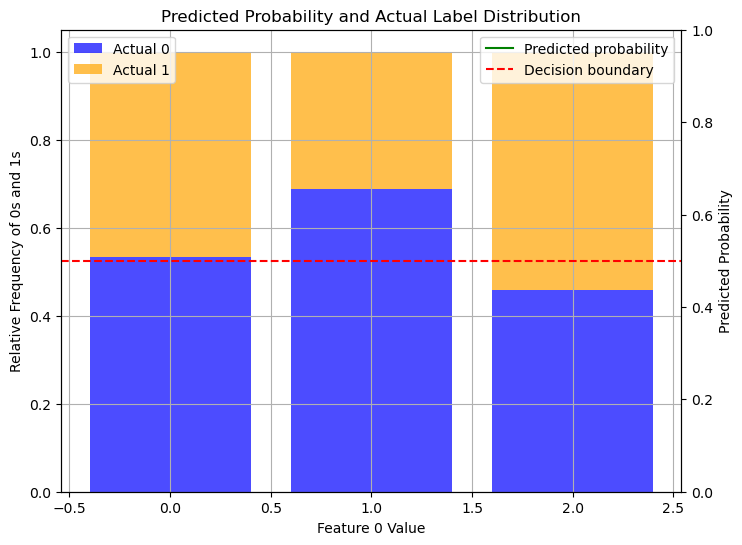

In [54]:


features_list = [{'ACTIN21_': {'type': 'numeric', 'missing_values': [np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

3.0
[2. 3. 3. ... 3. 1. 1.]
[3. 3. 3. ... 3. 2. 4.]


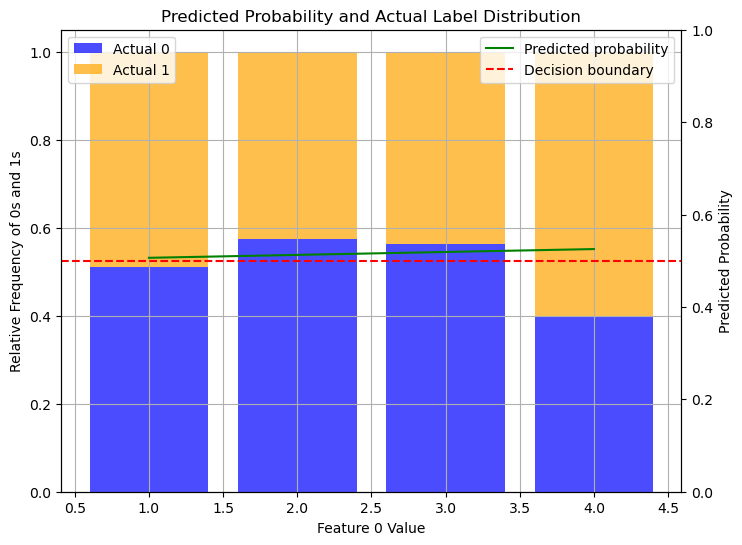

In [56]:


features_list = [{'_PACAT1': {'type': 'numeric', 'missing_values': [9], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

4.23
[6.96 3.22 3.78 ... 5.1  6.14 4.53]
[3.4  4.25 8.49 ... 2.46 4.44 8.12]


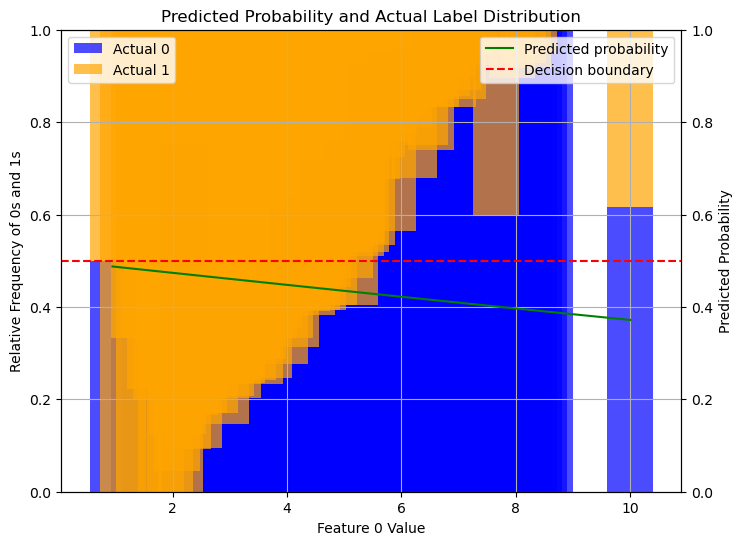

In [50]:


features_list = [{'FC60_': {'type': 'numeric', 'missing_values': [ 99900], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

24.69
[25.35 15.44 33.2  ... 27.65 20.95 24.32]
[18.77 28.1  21.73 ... 37.27 27.   18.75]


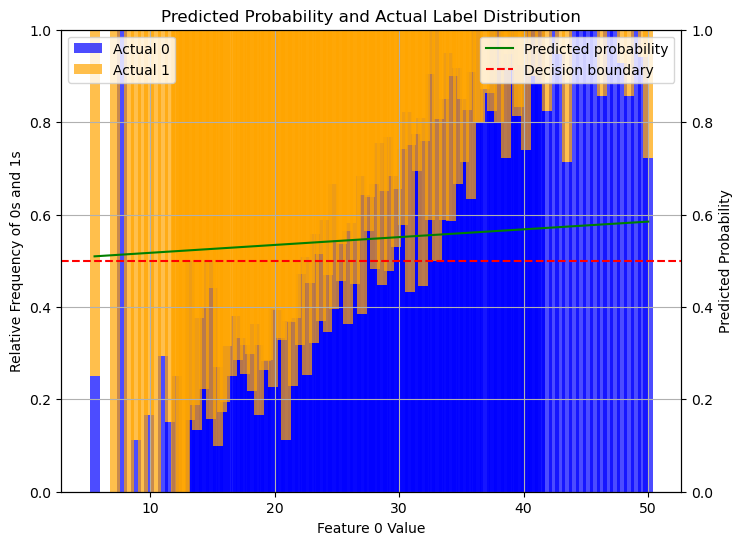

In [52]:


features_list = [{'MAXVO2_': {'type': 'numeric', 'missing_values': [ 99900], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)


3.5
[3.5 nan 5.  ... 4.8 4.5 nan]
[nan nan 5.3 ... nan nan nan]


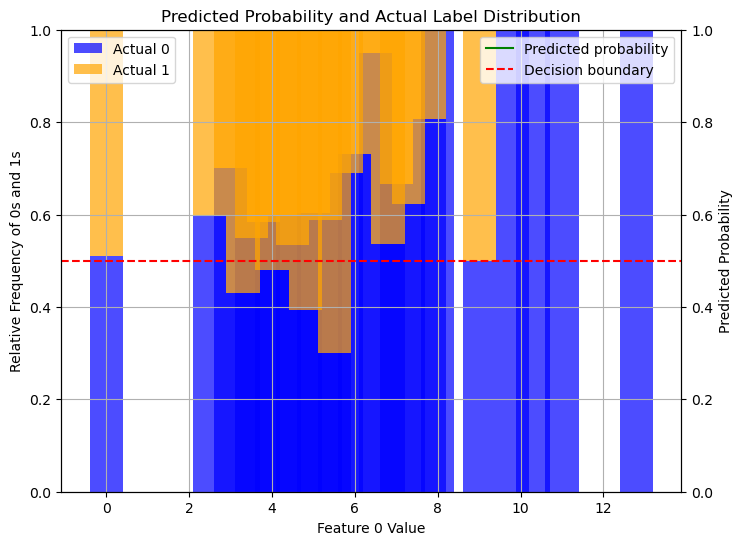

In [35]:

features_list = [{'METVL21_': {'type': 'numeric', 'missing_values': [ np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

2.0
[2. 2. 2. ... 2. 1. 1.]
[2. 2. 3. ... 1. 2. 3.]


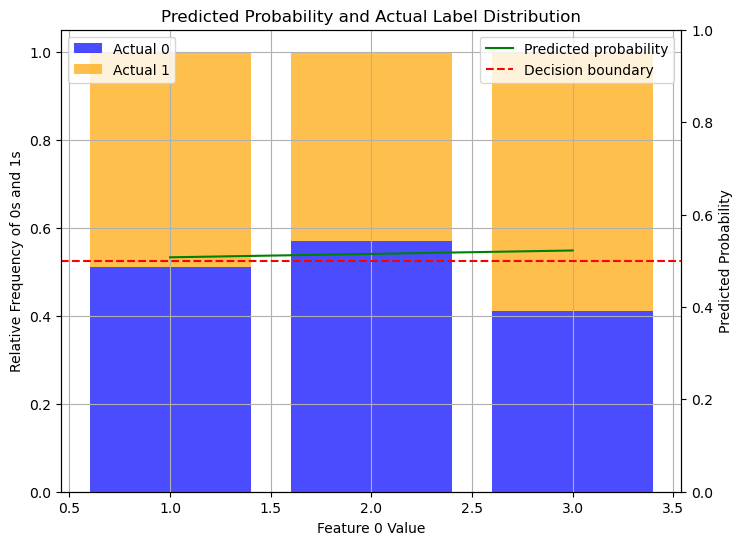

In [ ]:

features_list = [{'_PA300R2': {'type': 'numeric', 'map_value:' 'missing_values': [ 9,np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

3.0
[1. 3. 1. ... 2. 3. 2.]
[2. 3. 2. ... 2. 3. 3.]


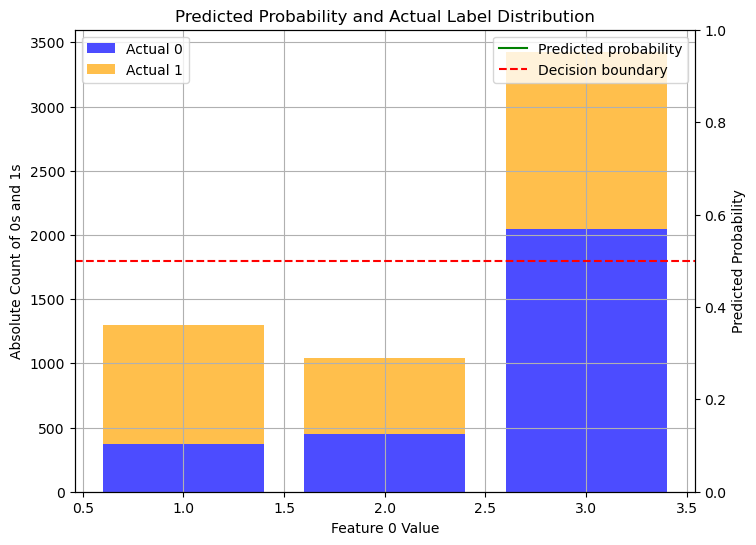

In [68]:

features_list = [{'_LMTACT1': {'type': 'numeric', 'missing_values': [ 9,np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= False, feature_index=0)

{'MEDCOST': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 1 ... 0 0 0]


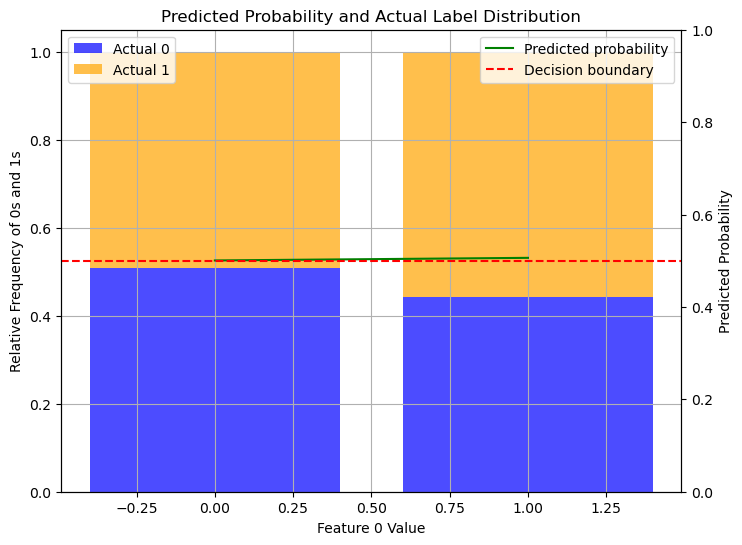

{'BLOODCHO': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[1 1 1 ... 1 1 1]


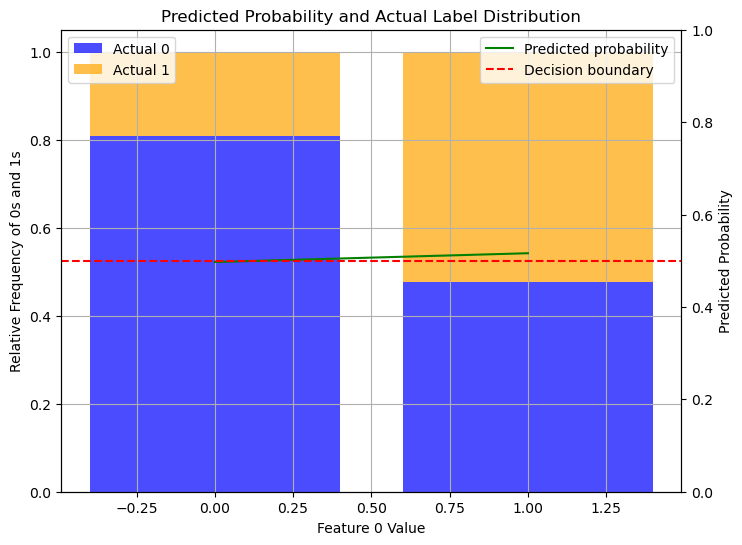

{'ASTHNOW': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


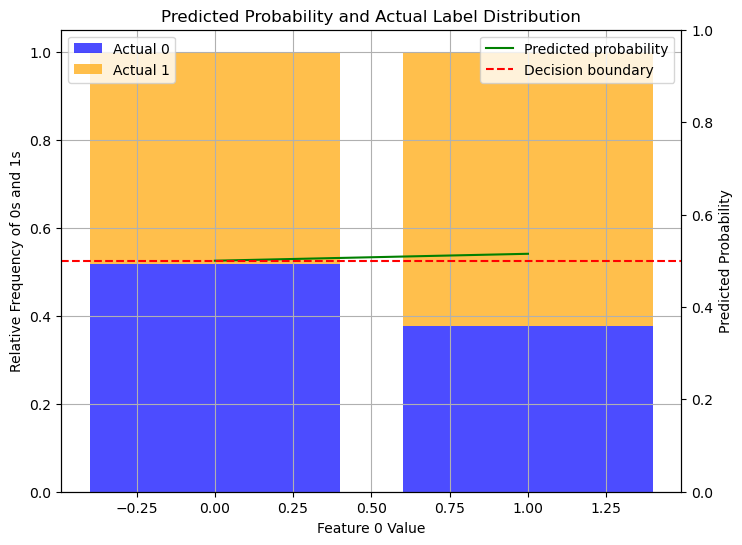

{'CHCSCNCR': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 1]


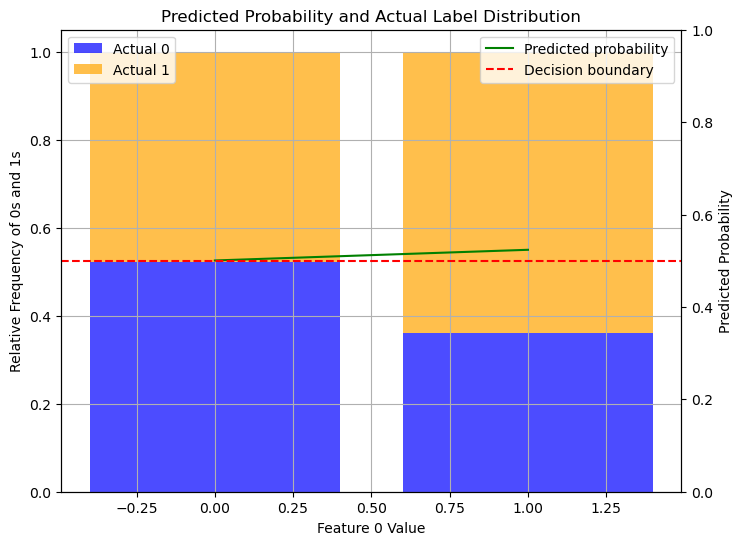

{'CHCOCNCR': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[1 1 1 ... 0 0 0]


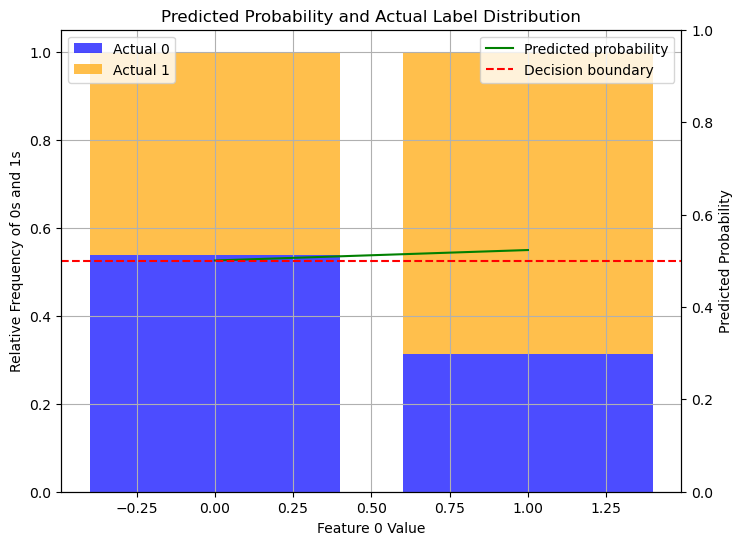

{'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 1 0 ... 0 0 0]


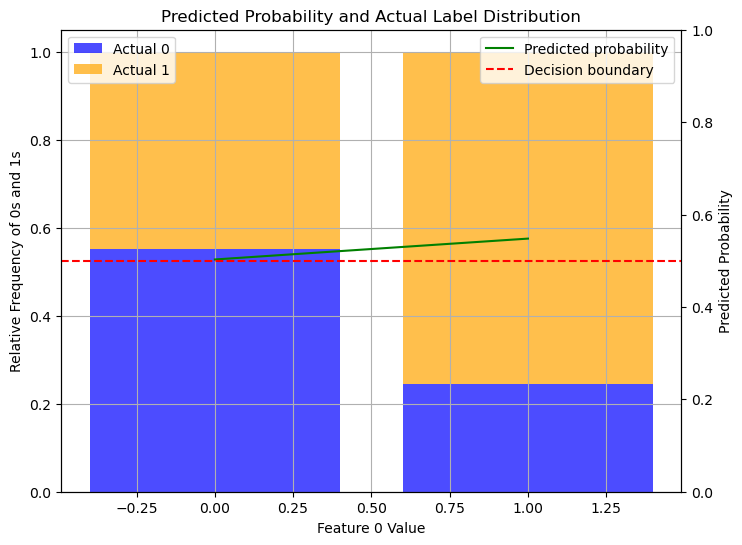

{'CHCKIDNY': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


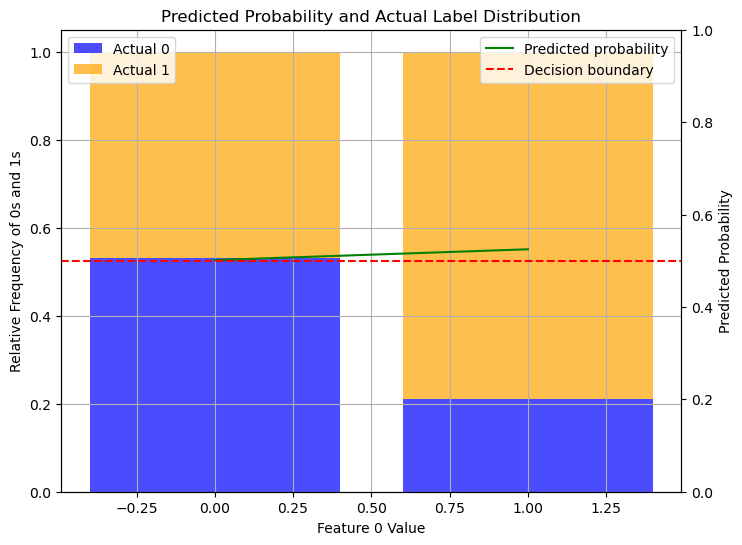

{'NUMHHOL2': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


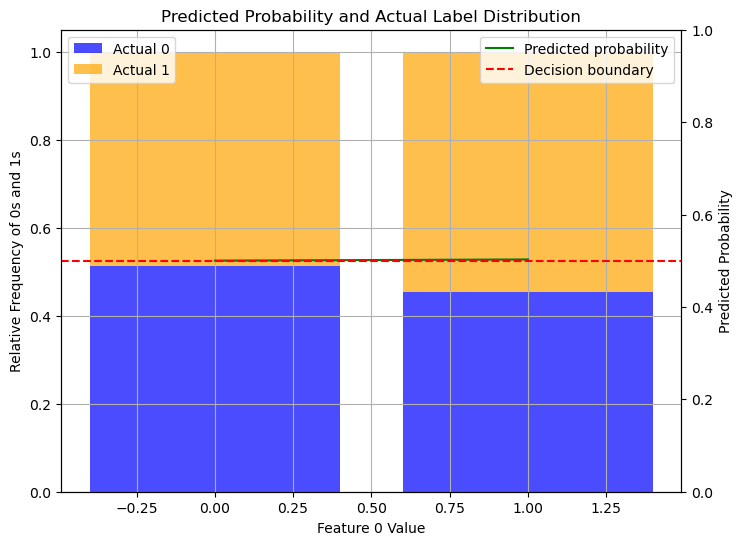

{'VETERAN3': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[1 0 1 ... 1 0 0]


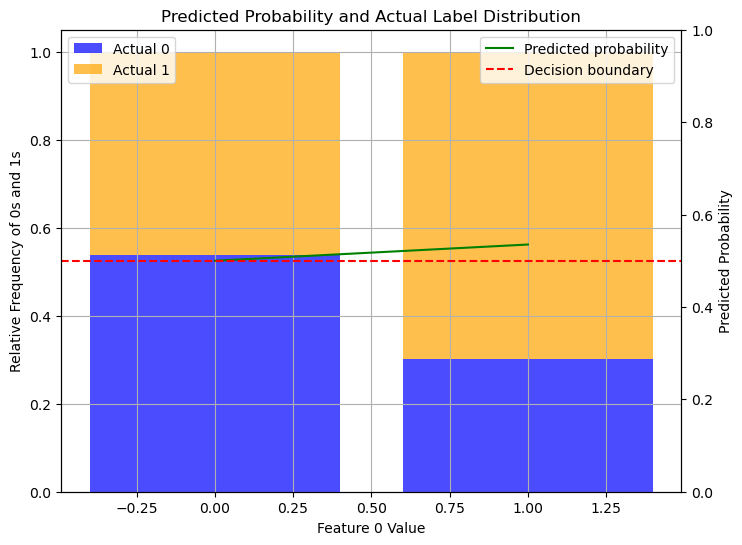

{'INTERNET': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[1 1 0 ... 1 1 1]


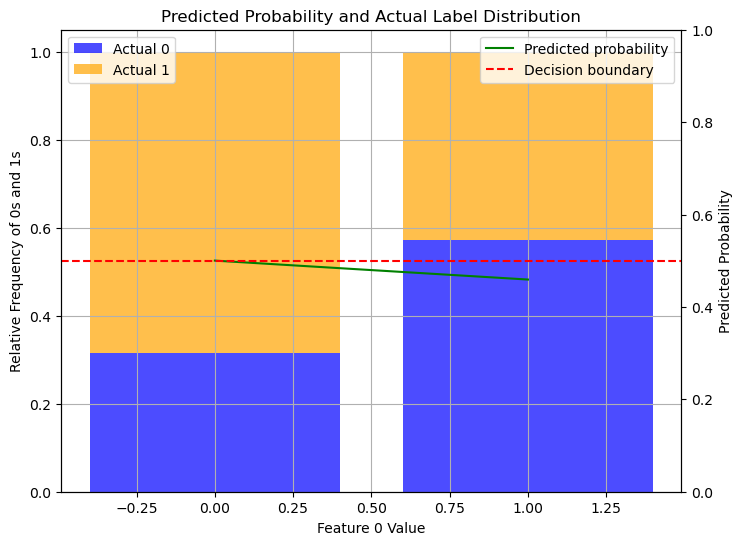

{'PREGNANT': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


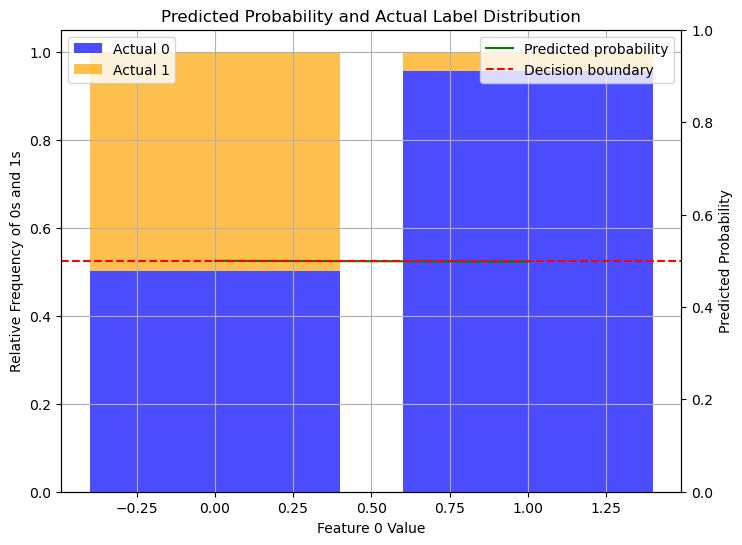

{'LMTJOIN3': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


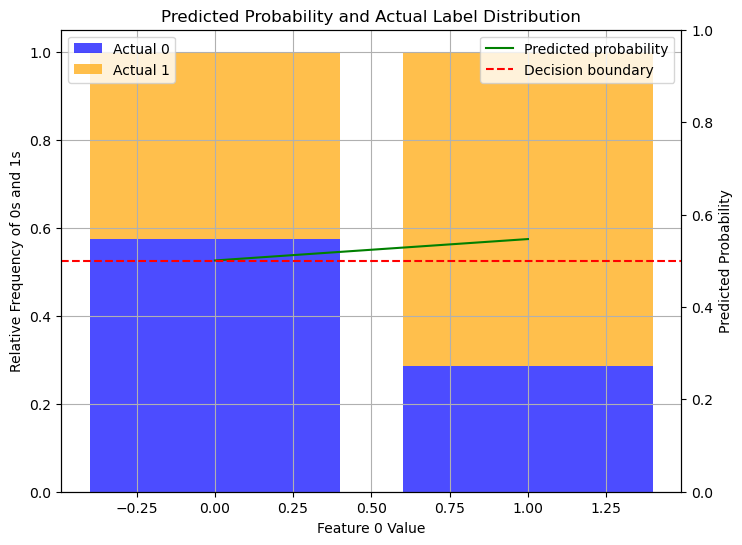

{'ARTHDIS2': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 1 1 ... 1 0 0]


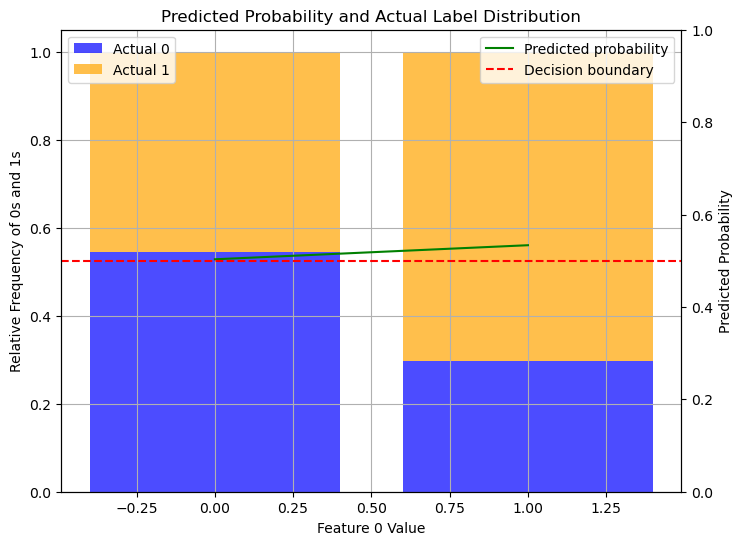

In [79]:


features_list = [{'MEDCOST': {'type': 'binary', 'missing_values': [ 7,9,np.nan]}},
                 {'BLOODCHO': {'type': 'binary', 'missing_values': [7, 9,np.nan]}},
                 {'ASTHNOW': {'type': 'binary', 'missing_values': [ 7,9,np.nan]}},
                 {'CHCSCNCR': {'type': 'binary', 'missing_values': [ 7,9,np.nan]}},
                 {'CHCOCNCR': {'type': 'binary', 'missing_values': [ 7,9,np.nan]}},
                 {'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9,np.nan]}},
                 {'CHCKIDNY': {'type': 'binary', 'missing_values': [ 7,9,np.nan]}},
                  {'NUMHHOL2': {'type': 'binary', 'missing_values': [ 7,9,np.nan]}},
                  {'VETERAN3': {'type': 'binary', 'missing_values': [ 7,9,np.nan]}},
                  {'INTERNET': {'type': 'binary', 'missing_values': [7, 9,np.nan]}},
                  {'PREGNANT': {'type': 'binary', 'missing_values': [7, 9,np.nan]}},
                  {'LMTJOIN3': {'type': 'binary', 'missing_values': [7, 9,np.nan]}},
                  {'ARTHDIS2': {'type': 'binary', 'missing_values': [ 7,9,np.nan]}}
                  

                  
                  
                  
            
                 

                 
                 
                 ]
for feature in features_list:
    print(feature)
    analyze_correlation(feature, X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

{'_PNEUMO2': {'type': 'binary', 'missing_values': [9, nan]}}
[0 0 0 ... 0 0 1]


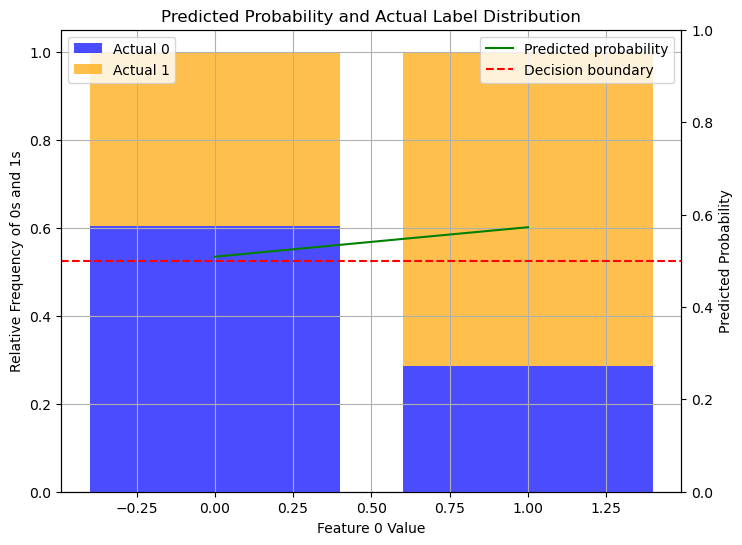

{'_AIDTST3': {'type': 'binary', 'missing_values': [9, nan]}}
[1 1 0 ... 1 1 0]


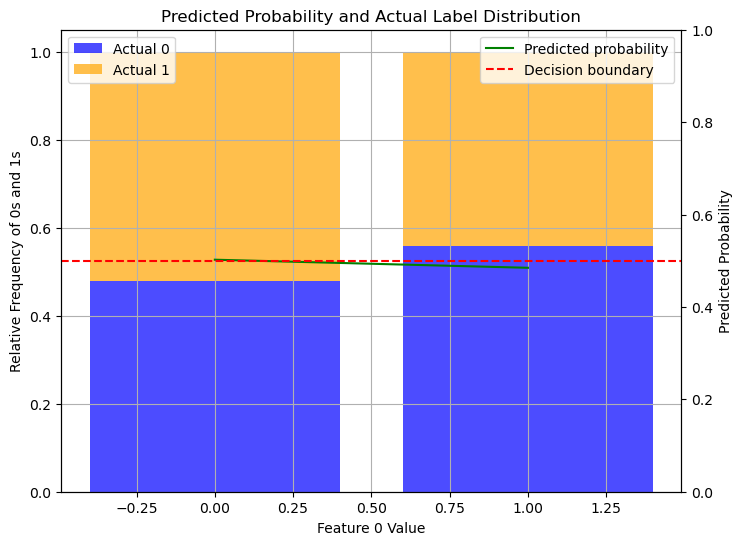

{'_RFSEAT3': {'type': 'binary', 'missing_values': [9, nan]}}
[1 1 1 ... 0 1 1]


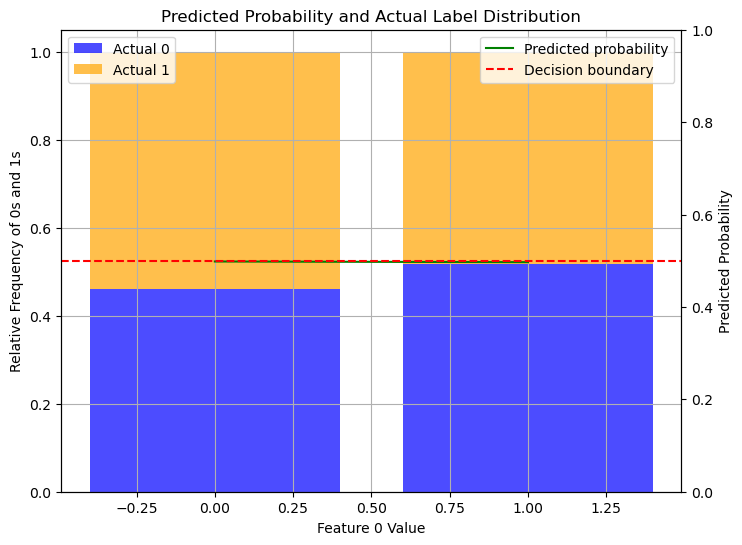

{'_VEGLT1': {'type': 'binary', 'missing_values': [9, nan]}}
[1 0 1 ... 1 0 1]


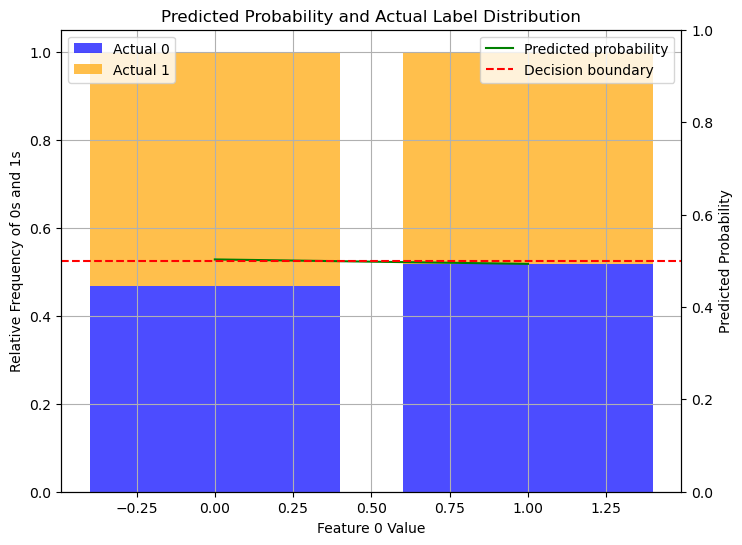

{'_FRTLT1': {'type': 'binary', 'missing_values': [9, nan]}}
[1 0 1 ... 0 1 1]


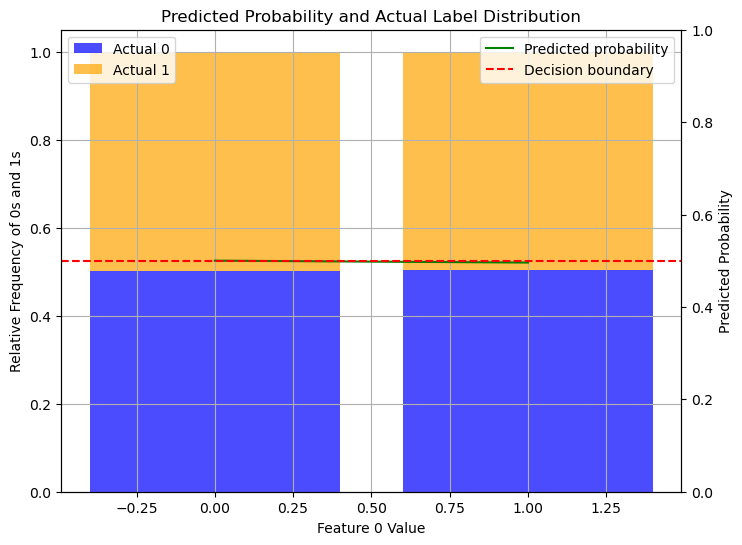

{'_RFBMI5': {'type': 'binary', 'missing_values': [9, nan]}}
[1 1 0 ... 0 1 1]


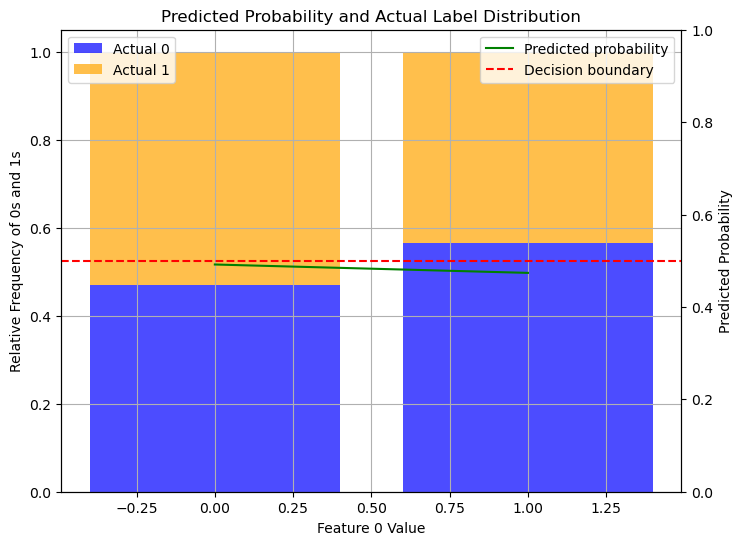

{'_HISPANC': {'type': 'binary', 'missing_values': [9, nan]}}
[0 1 0 ... 1 0 0]


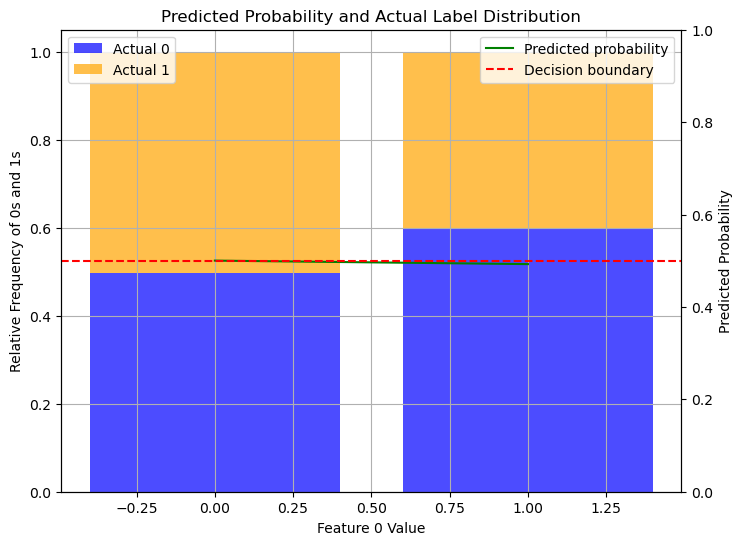

{'_CASTHM1': {'type': 'binary', 'missing_values': [9, nan]}}
[1 1 1 ... 1 1 1]


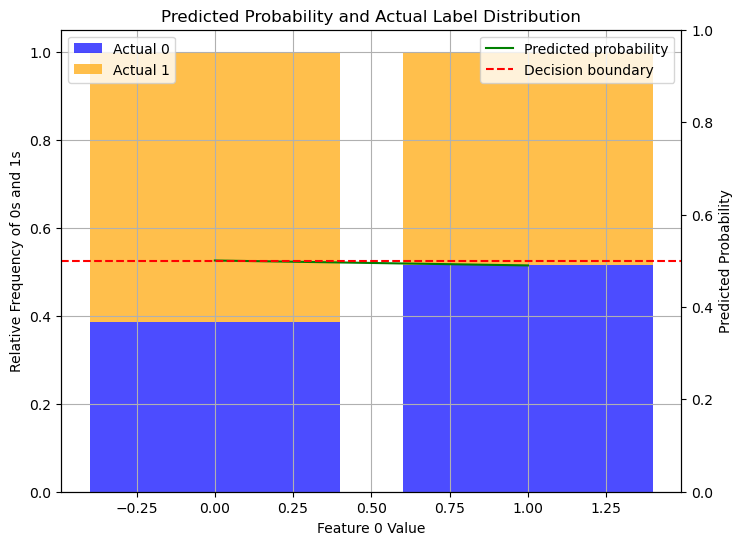

{'_LTASTH1': {'type': 'binary', 'missing_values': [9, nan]}}
[1 1 1 ... 1 1 1]


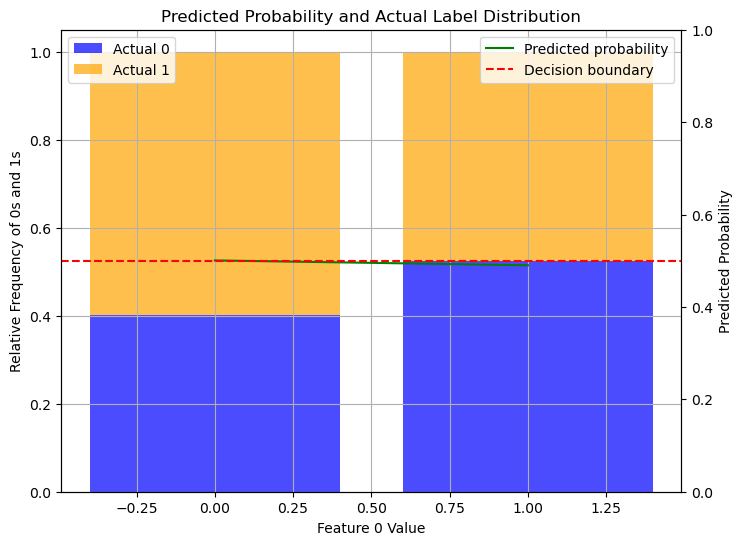

{'_RFCHOL': {'type': 'binary', 'missing_values': [9, nan]}}
[0 0 0 ... 0 0 0]


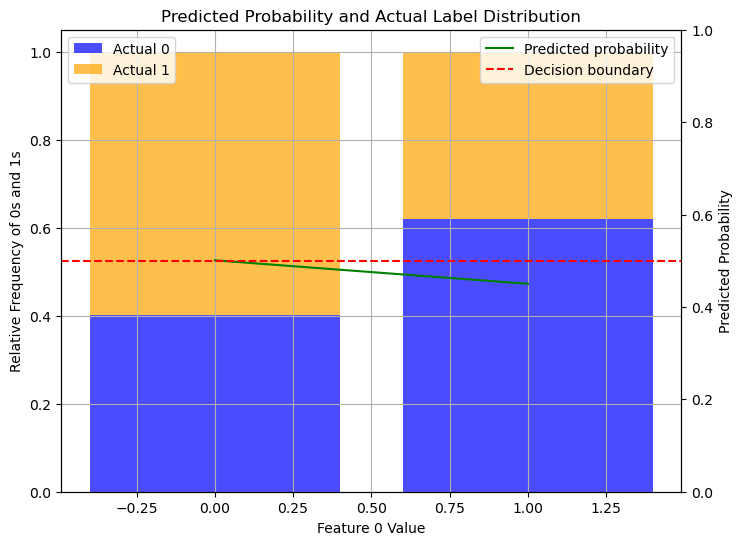

{'_RFHYPE5': {'type': 'binary', 'missing_values': [9, nan]}}
[1 1 1 ... 1 0 0]


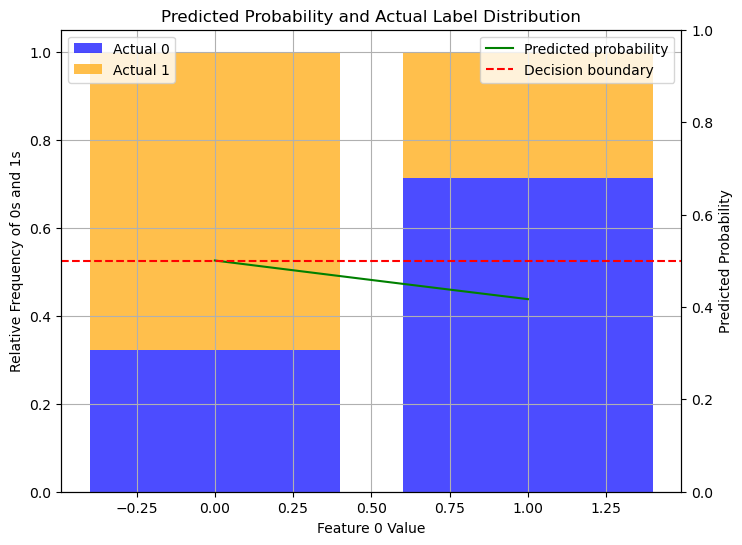

{'_HCVU651': {'type': 'binary', 'missing_values': [9, nan]}}
[0 0 0 ... 0 0 0]


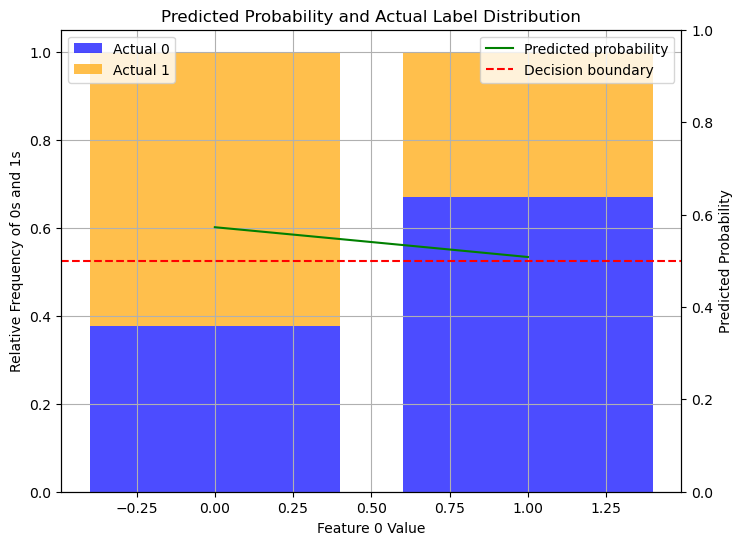

{'_RFHLTH': {'type': 'binary', 'missing_values': [9, nan]}}
[1 1 0 ... 0 0 0]


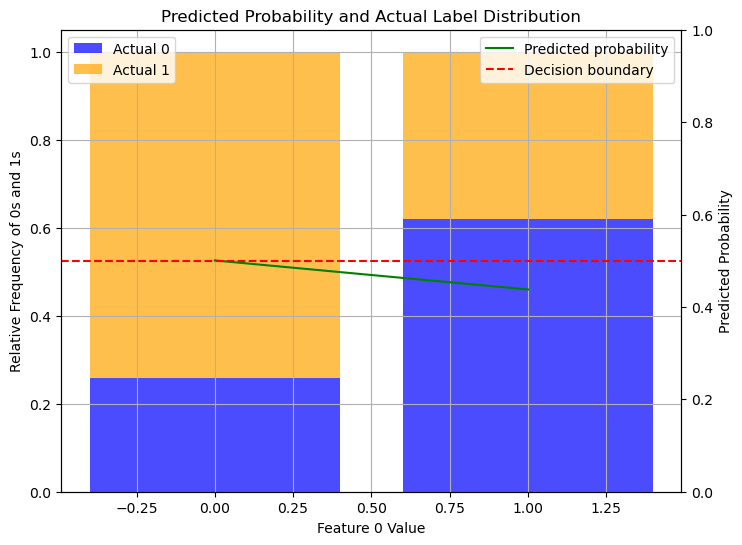

In [78]:


features_list = [{'_PNEUMO2': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                 {'_AIDTST3': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                 {'_RFSEAT3': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                 {'_VEGLT1': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                 {'_FRTLT1': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                 {'_RFBMI5': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                 {'_HISPANC': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                  {'_CASTHM1': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                  {'_LTASTH1': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                  {'_RFCHOL': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                  {'_RFHYPE5': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                  {'_HCVU651': {'type': 'binary', 'missing_values': [ 9,np.nan]}},
                  {'_RFHLTH': {'type': 'binary', 'missing_values': [ 9,np.nan]}}
                  

                  
                  
                  
            
                 

                 
                 
                 ]
for feature in features_list:
    print(feature)
    analyze_correlation(feature, X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[1 0 1 ... 0 0 1]


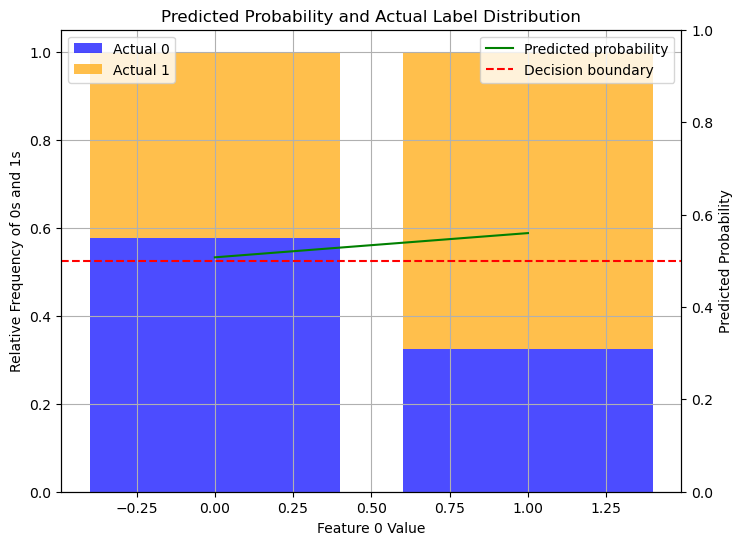

In [74]:


features_list = [{'_FLSHOT6': {'type': 'binary', 'missing_values': [ 9,np.nan]}}]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[1 1 1 ... 1 1 0]


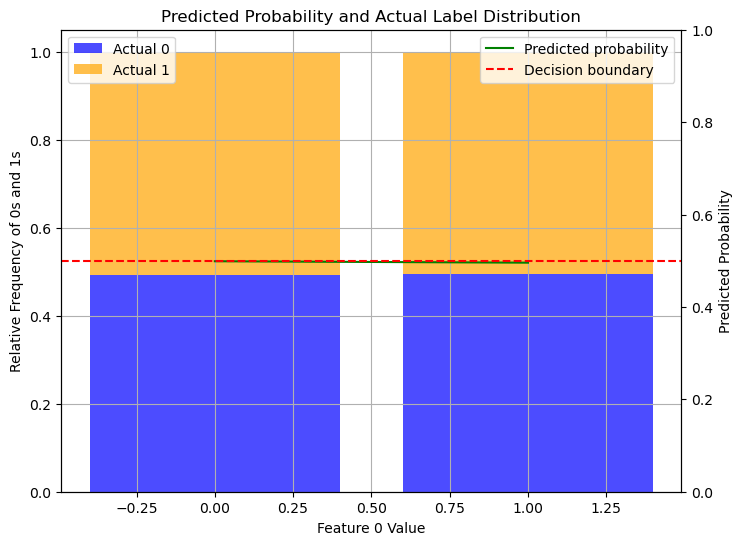

In [72]:

features_list = [{'_RFSEAT2': {'type': 'binary', 'missing_values': [ 9,np.nan]}}]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

4.0
[2. 4. 2. ... 3. 4. 1.]
[3. 4. 4. ... 1. 4. 1.]


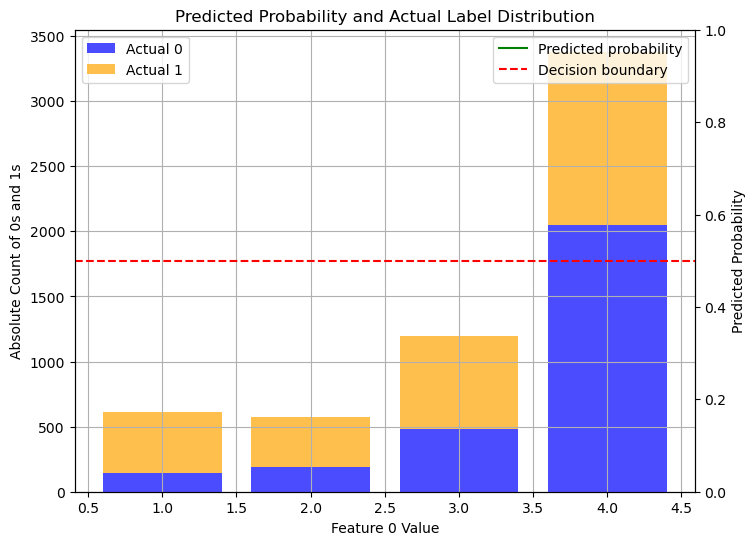

In [73]:



features_list = [{'_LMTSCL1': {'type': 'numeric', 'missing_values': [ 9,np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= False, feature_index=0)


2.0
[1. 2. 2. ... 2. 1. 1.]
[1. 1. 2. ... 3. 1. 1.]


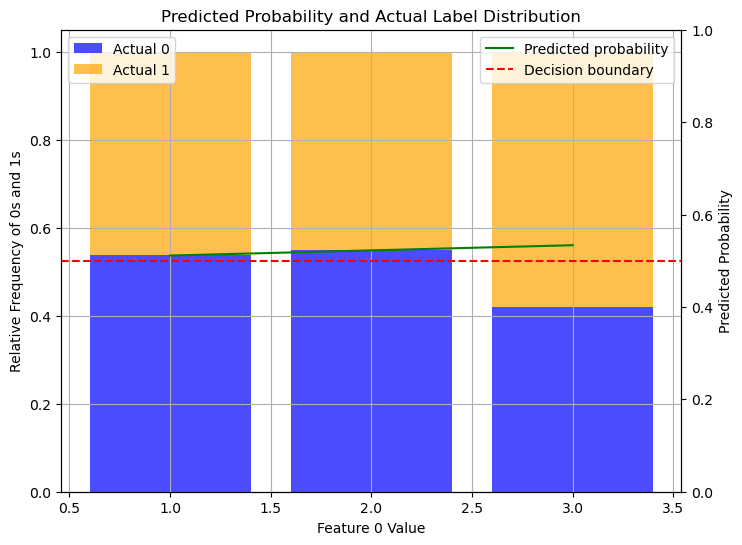

In [59]:


features_list = [{'_PA150R2': {'type': 'numeric', 'missing_values': [ 9,np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[0 0 0 ... 0 0 0]


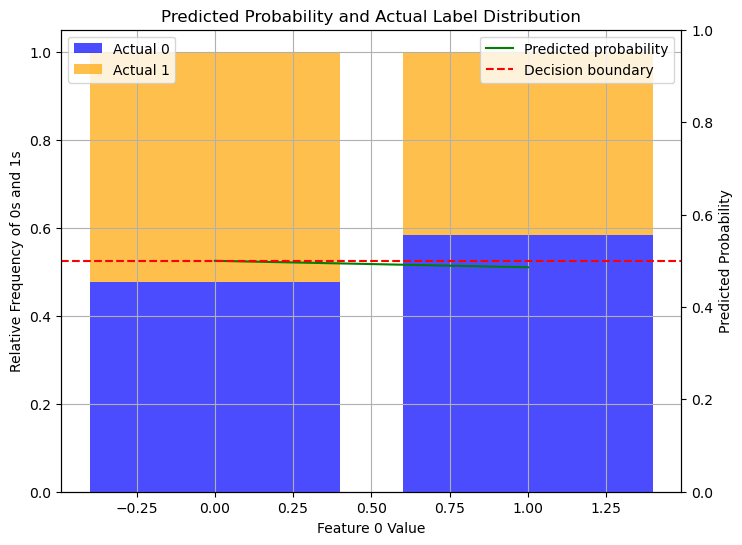

In [64]:

features_list = [{'_PASTAE1': {'type': 'binary', 'missing_values': [9, np.nan]}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)


3.0
[2. 3. 4. ... 4. 2. 1.]
[3. 4. 4. ... 3. 4. 2.]


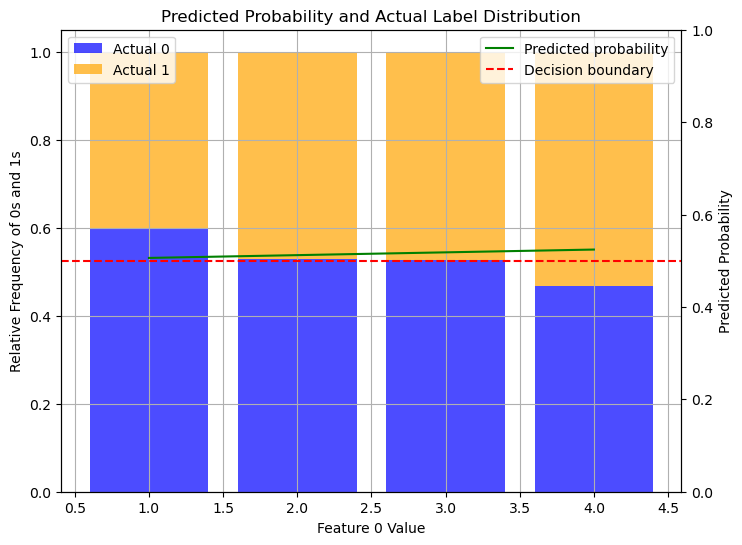

In [63]:


features_list = [{'_PAREC1': {'type': 'numeric', 'missing_values': [9, np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)


3.5
[3.5 nan 3.5 ... 3.5 3.5 nan]
[4.5 4.5 nan ... 3.5 3.5 nan]


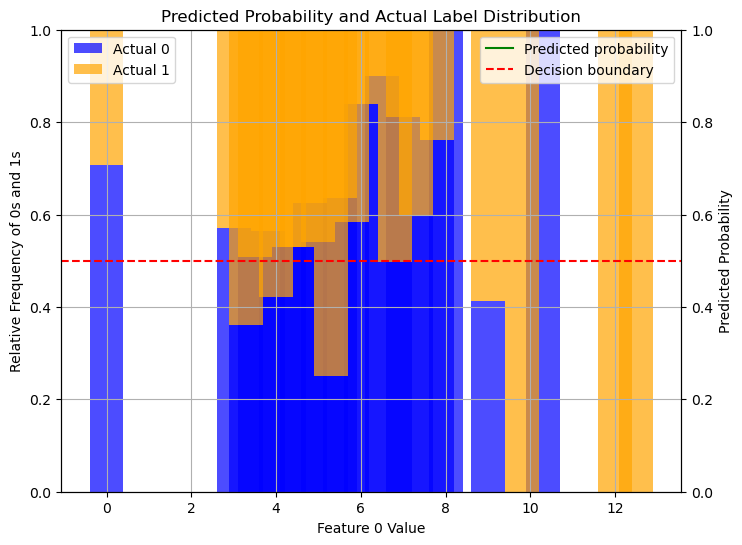

In [34]:

features_list = [{'METVL11_': {'type': 'numeric', 'missing_values': [ np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[1 1 0 ... 0 1 1]


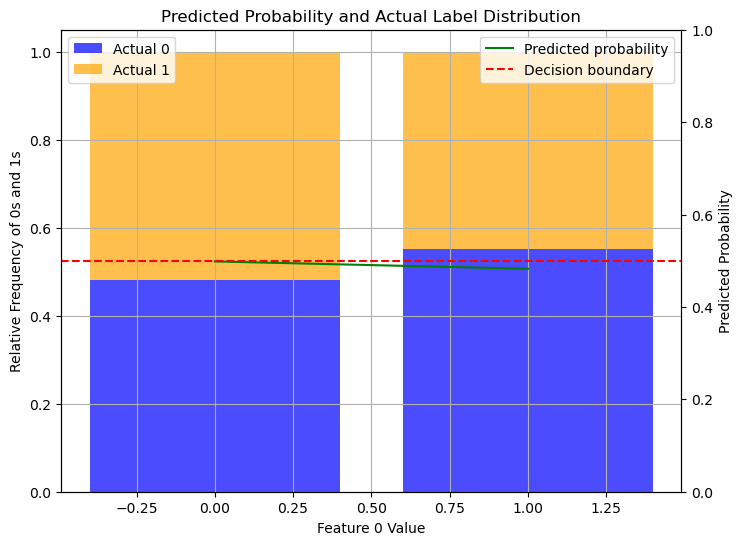

In [62]:


features_list = [{'_PASTRNG': {'type': 'binary', 'missing_values': [9, np.nan]}}]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[0 0 0 ... 0 0 0]


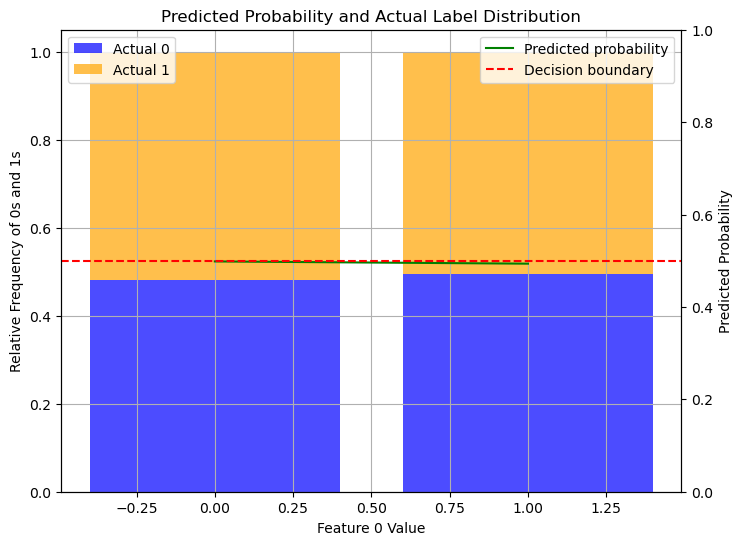

In [61]:

features_list = [{'_PA30021': {'type': 'binary', 'missing_values': [9, np.nan]}}]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[1 0 0 ... 0 0 0]


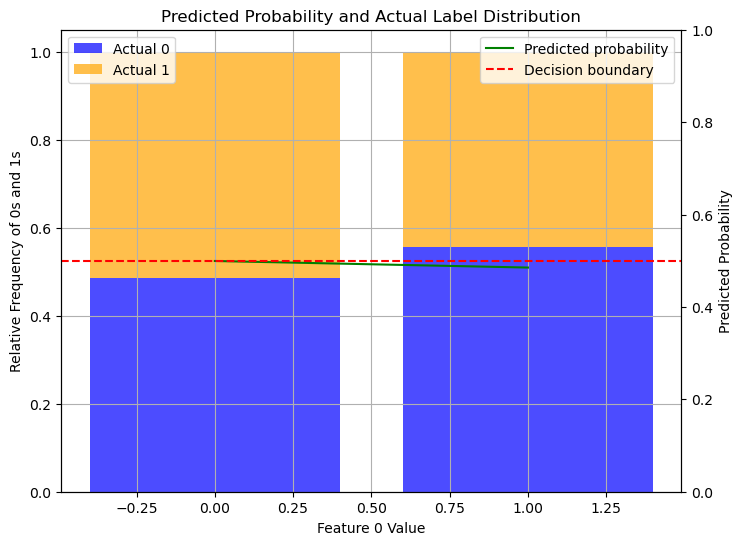

In [57]:

features_list = [{'_PAINDX1': {'type': 'binary', 'missing_values': [9, np.nan]}}]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[0 0 0 ... 1 1 0]


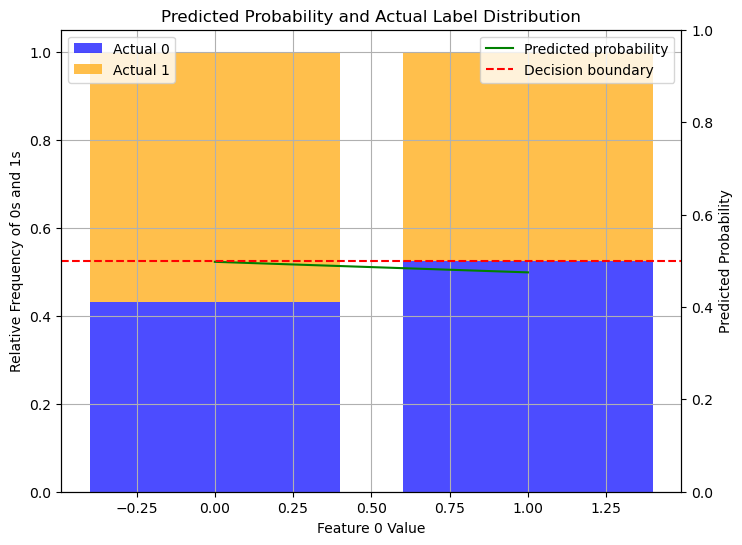

In [33]:
features_list = [{'_TOTINDA': {'type': 'binary', 'missing_values': [9, np.nan]}}]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[0 1 1 ... 1 1 1]


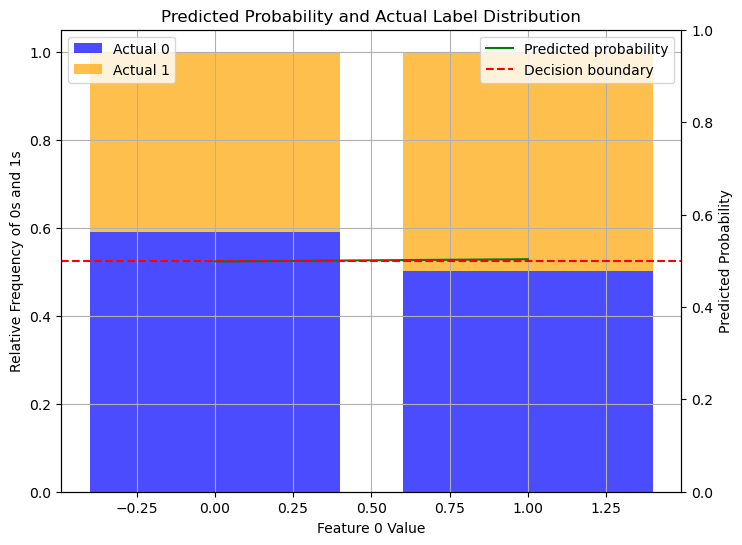

In [30]:
features_list = [{'_RFDRHV5': {'type': 'binary', 'missing_values': [9, np.nan]}}]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

0.0
[100.   0. 100. ...   0.   0.   0.]
[  0. 100.   0. ...   0.   0.   0.]


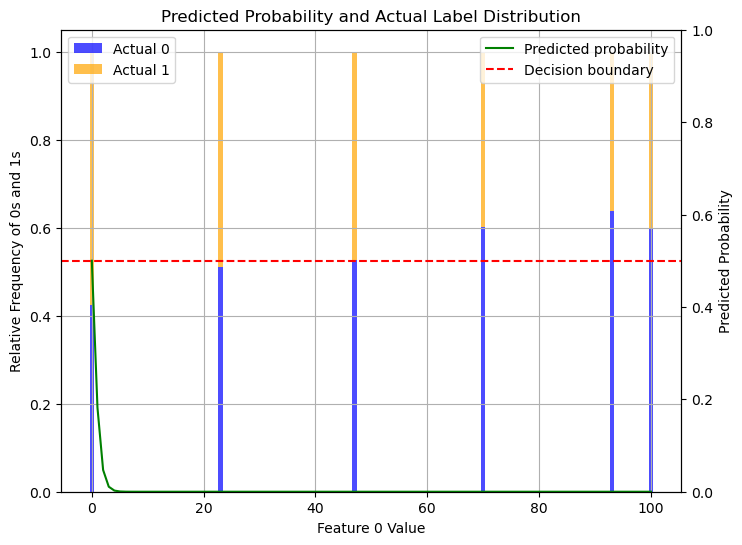

In [31]:

features_list = [{'_DRNKWEK': {'type': 'numeric', 'missing_values': [99900, np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[1 1 1 ... 1 1 1]


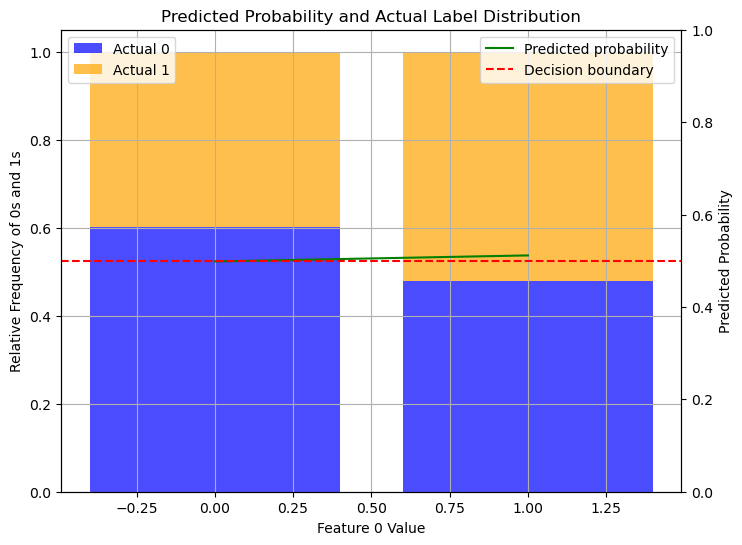

In [24]:
features_list = [{'_RFBING5': {'type': 'binary', 'missing_values': [9, np.nan]}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

1.0
[1. 1. 3. ... 1. 1. 2.]
[1. 1. 1. ... 1. 1. 1.]


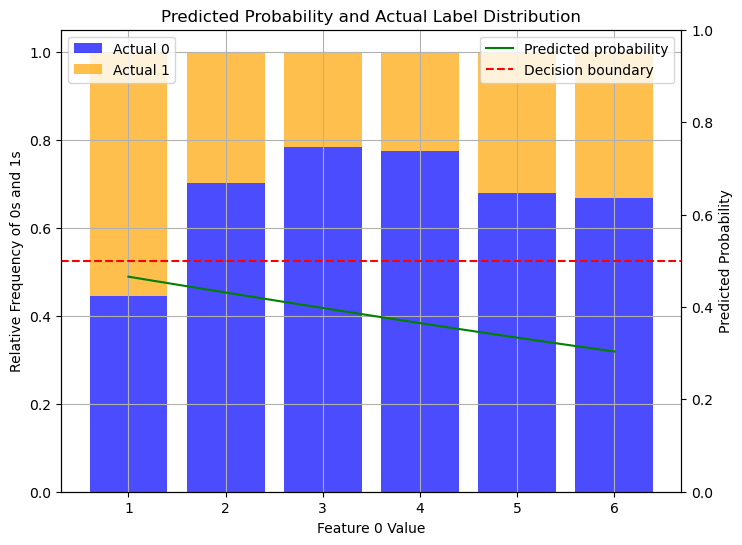

In [22]:
features_list = [{'_CHLDCNT': {'type': 'numeric', 'missing_values': [9, np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

4.0
[3. 2. 5. ... 4. 4. 5.]
[2. 4. 4. ... 4. 4. 5.]


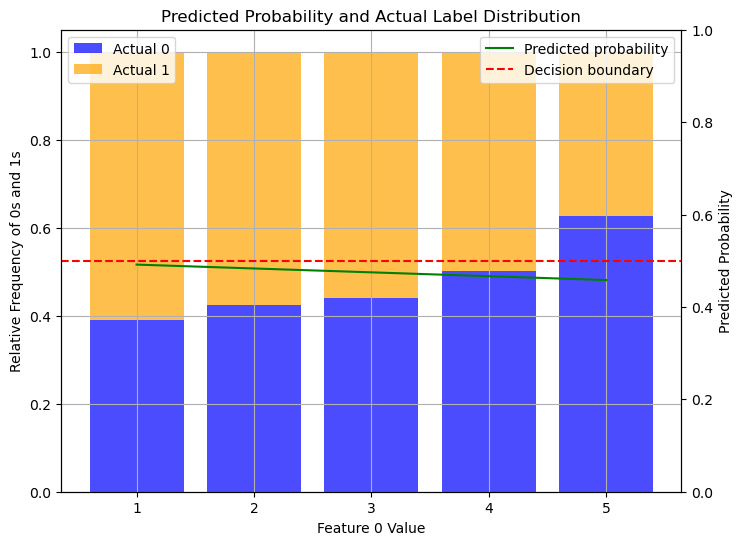

In [20]:
features_list = [{'_INCOMG': {'type': 'numeric', 'missing_values': [9, np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

5.0
[3. 6. 6. ... 4. 3. 6.]
[6. 3. 6. ... 5. 6. 6.]


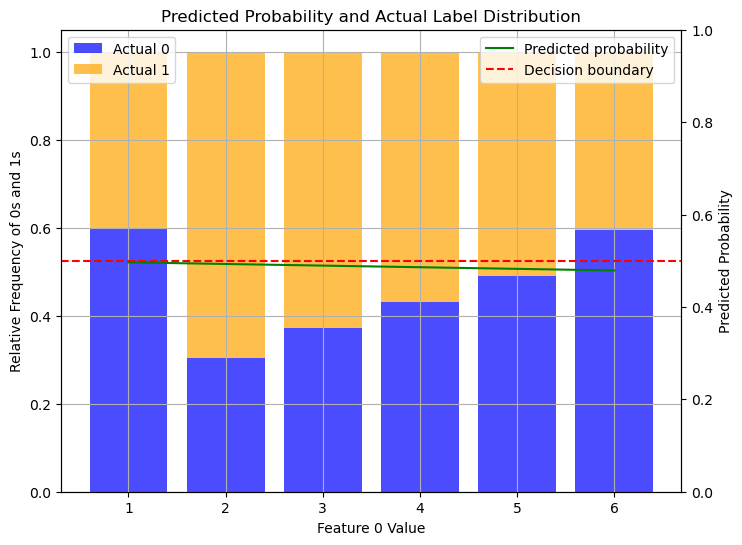

In [15]:
    #'EDUCA': {'type': 'numeric', 'missing_values': [9, np.nan], 'range': (1, 6)},  # Education level
    #'INCOME2': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'range': (1, 8)},
features_list = [{'EDUCA': {'type': 'numeric', 'missing_values': [9, np.nan], 'range': (1, 6)}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

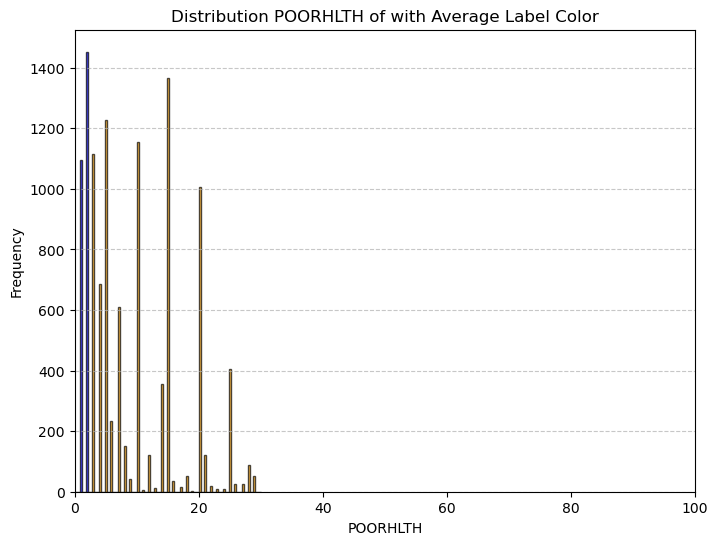

In [295]:
histogram_correlation(feature_name='POORHLTH', x_train=X_train_balanced, Y_train=Y_train_balanced, max_x=100)

[0 0 0 ... 0 0 0]


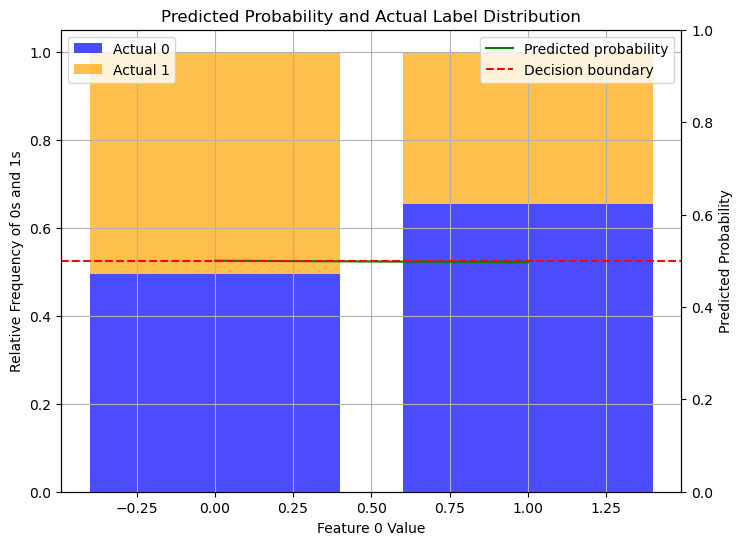

In [302]:
features_list = [{'POORHLTH': {'type': 'binary', 'missing_values': [np.nan]}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

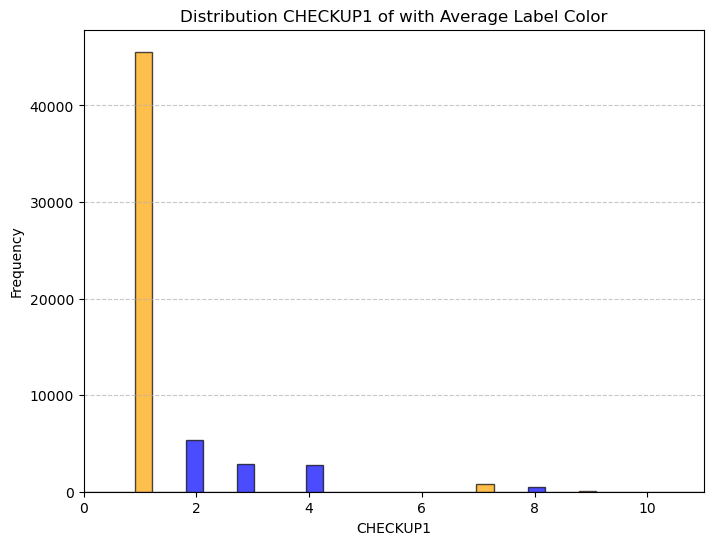

In [258]:
histogram_correlation(feature_name='CHECKUP1', x_train=X_train_balanced, Y_train=Y_train_balanced, max_x=11)

In [197]:
pain_idx = features.index('JOINPAIN')
X_train_balanced[:30,pain_idx]

array([nan, nan, nan, nan,  4., nan, nan, nan, nan,  4., nan,  2.,  5.,
       nan, nan, 10., nan, nan, nan, nan, nan, nan,  0., nan,  2.,  5.,
        5., nan, nan, nan])

[1 0 1 ... 1 1 1]


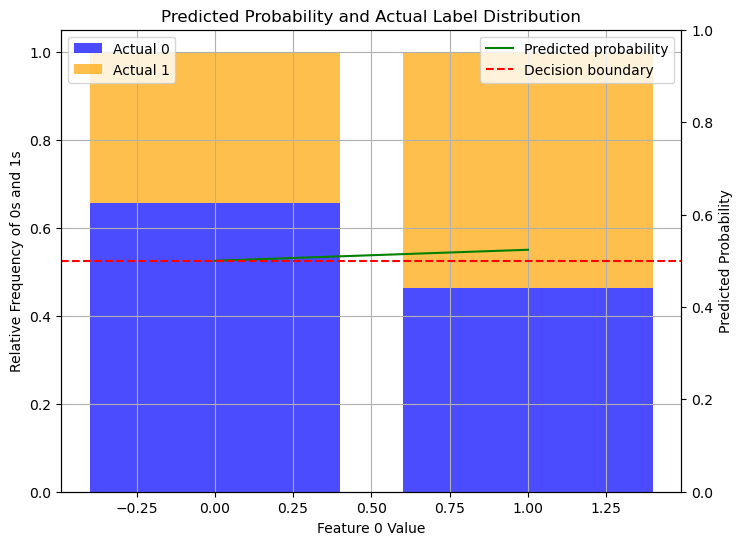

In [268]:
features_list = [{'CHECKUP1': {'type': 'binary', 'missing_values': [np.nan]}}]


analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

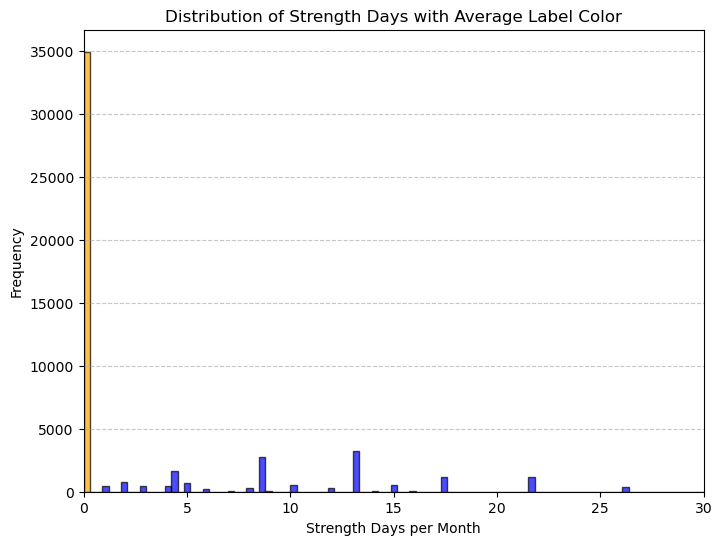

In [161]:
strength_index = features.index('STRENGTH')

# Balance the dataset
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]

# Extract STRENGTH values and corresponding labels
strength_values = X_train_balanced[:, strength_index]
y_labels = Y_train_balanced

# Define bins for STRENGTH
bins = np.linspace(0, 30, 100)  # Adjusted to cover the expected range for STRENGTH

# Calculate the average label per bin
bin_indices = np.digitize(strength_values, bins)
average_labels = []
for i in range(1, len(bins)):
    mask = bin_indices == i
    if mask.any():
        avg_label = y_labels[mask].mean()  # Calculate average label for the bin
        average_labels.append(avg_label)
    else:
        average_labels.append(0)  # Default to 0 if no samples in bin

# Plot the histogram with colored bins for STRENGTH
plt.figure(figsize=(8, 6))
for i in range(len(bins) - 1):
    bin_mask = (bin_indices == i + 1)
    bin_color = 'orange' if average_labels[i] >= 0.5 else 'blue'
    plt.hist(strength_values[bin_mask], bins=[bins[i], bins[i + 1]], color=bin_color, edgecolor='black', alpha=0.7)

plt.xlabel('Strength Days per Month')
plt.xlim(0, 30)

plt.ylabel('Frequency')
plt.title('Distribution of Strength Days with Average Label Color')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

[0 1 1 ... 1 0 0]


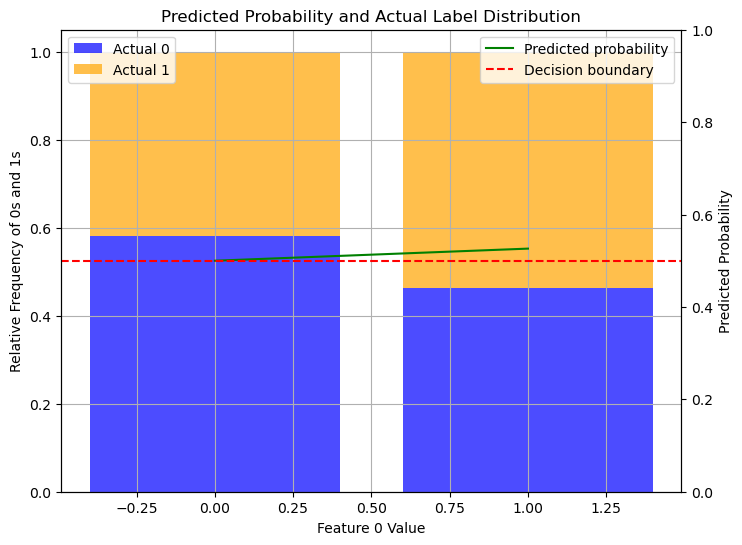

In [176]:

X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
features_list = [{'STRENGTH': {'type': 'binary', 'missing_values': [ np.nan]}}]

analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=100, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

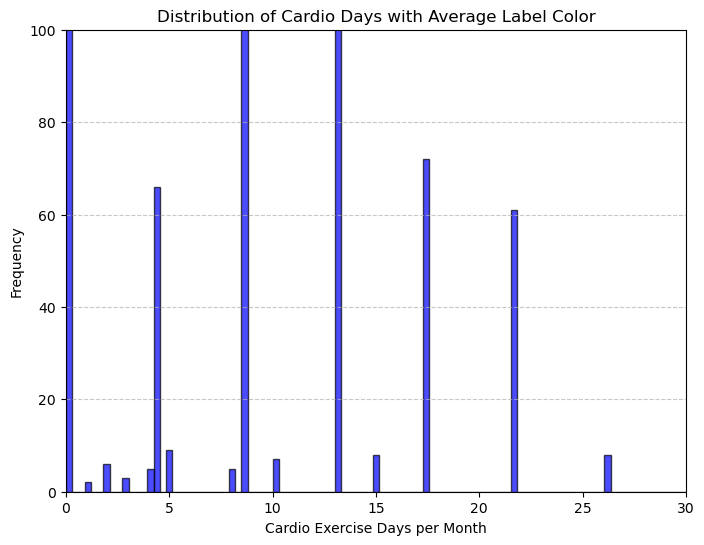

In [162]:
# EXEROFT1 NO INFO
exer_index = features.index('EXEROFT1')

# Balance the dataset
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]


exer_values = X_train_balanced[:, exer_index]
y_labels = Y_train_balanced

# Define bins for STRENGTH
bins = np.linspace(0, 30, 100)  # Adjusted to cover the expected range for STRENGTH

# Calculate the average label per bin
bin_indices = np.digitize(exer_values, bins)
average_labels = []
for i in range(1, len(bins)):
    mask = bin_indices == i
    if mask.any():
        avg_label = y_labels[mask].mean()  # Calculate average label for the bin
        average_labels.append(avg_label)
    else:
        average_labels.append(0)  # Default to 0 if no samples in bin

# Plot the histogram with colored bins for STRENGTH
plt.figure(figsize=(8, 6))
for i in range(len(bins) - 1):
    bin_mask = (bin_indices == i + 1)
    bin_color = 'orange' if average_labels[i] >= 0.5 else 'blue'
    plt.hist(strength_values[bin_mask], bins=[bins[i], bins[i + 1]], color=bin_color, edgecolor='black', alpha=0.7)

plt.xlabel('Cardio Exercise Days per Month')
plt.xlim(0, 30)
plt.ylim(0,100)
plt.ylabel('Frequency')
plt.title('Distribution of Cardio Days with Average Label Color')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

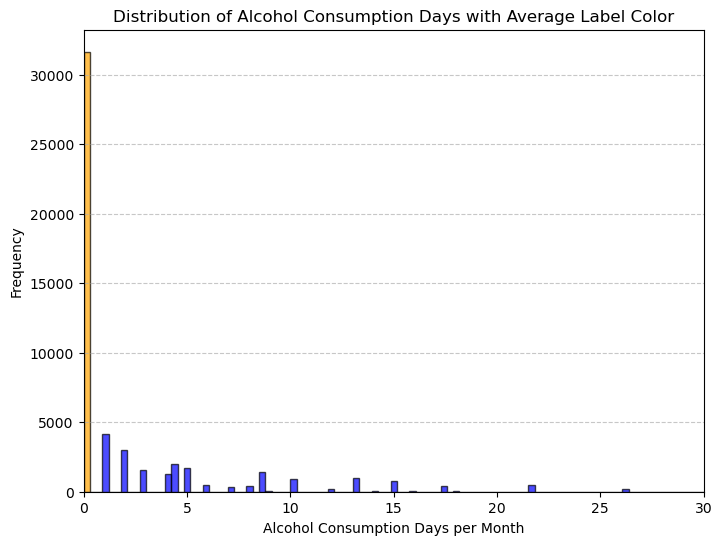

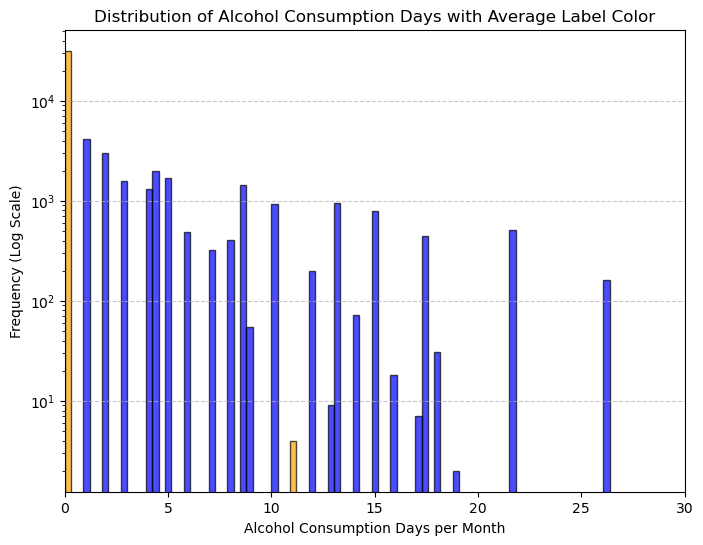

In [165]:
# ALCDAYS5

alcday_index = features.index('ALCDAY5')

# Balance the dataset
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]

# Extract ALCDAY5 values and corresponding labels
alcday_values = X_train_balanced[:, alcday_index]
y_labels = Y_train_balanced

# Define bins for ALCDAY5 (adjust range based on expected alcohol consumption days)
bins = np.linspace(0, 30, 100)  # 100 bins to cover a typical monthly range of alcohol consumption

# Calculate the average label per bin
bin_indices = np.digitize(alcday_values, bins)
average_labels = []
for i in range(1, len(bins)):
    mask = bin_indices == i
    if mask.any():
        avg_label = y_labels[mask].mean()  # Calculate average label for the bin
        average_labels.append(avg_label)
    else:
        average_labels.append(0)  # Default to 0 if no samples in bin

# Plot the histogram with colored bins for ALCDAY5
plt.figure(figsize=(8, 6))
for i in range(len(bins) - 1):
    bin_mask = (bin_indices == i + 1)
    bin_color = 'orange' if average_labels[i] >= 0.5 else 'blue'
    plt.hist(alcday_values[bin_mask], bins=[bins[i], bins[i + 1]], color=bin_color, edgecolor='black', alpha=0.7)




[0 0 0 ... 1 1 0]


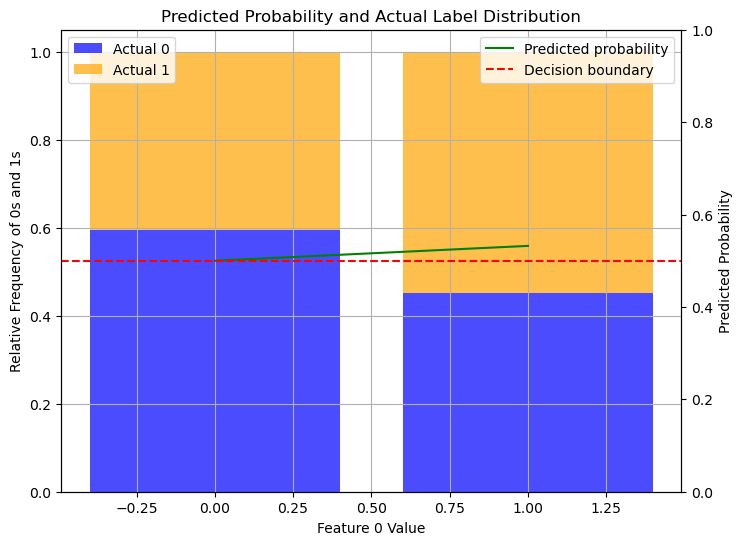

In [175]:

X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
features_list = [{'ALCDAY5': {'type': 'binary', 'missing_values': [ np.nan]}}]

analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=100, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[30.  0.  0. ...  8.  0.  0.]


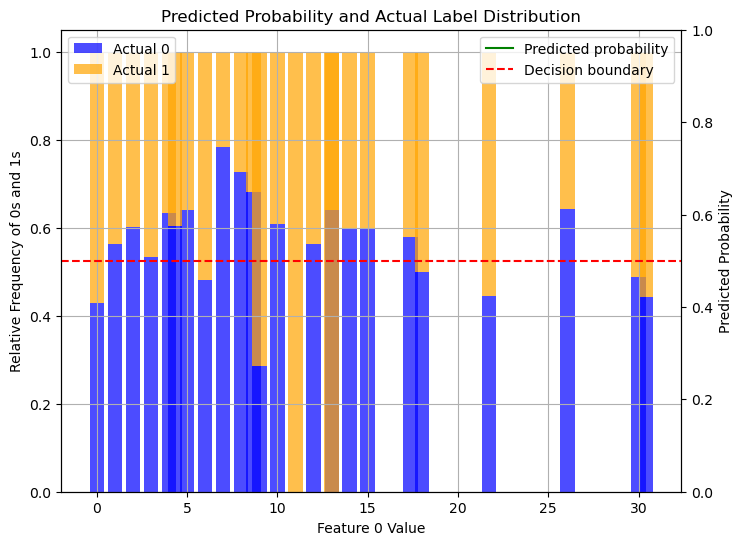

In [170]:

X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
features_list = [{'ALCDAY5': {'type': 'numeric', 'missing_values': [777, 999, np.nan], 'map_value': {888: 0}, 'range': (0, 431)}}]

analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=100, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

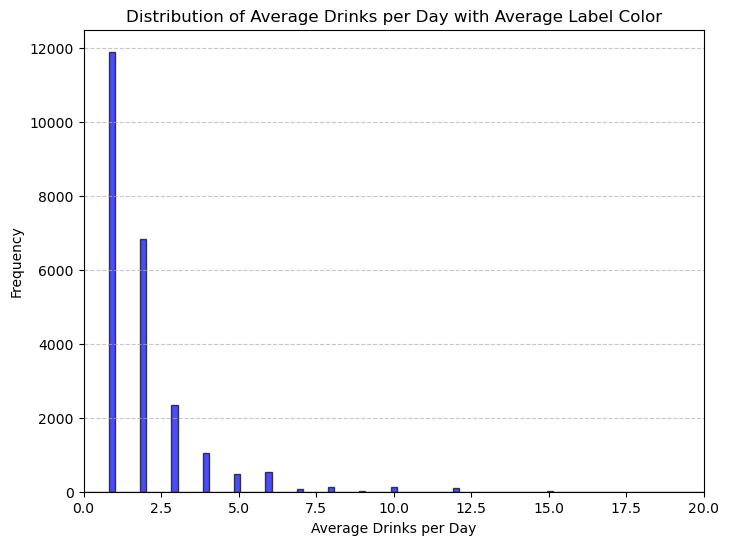

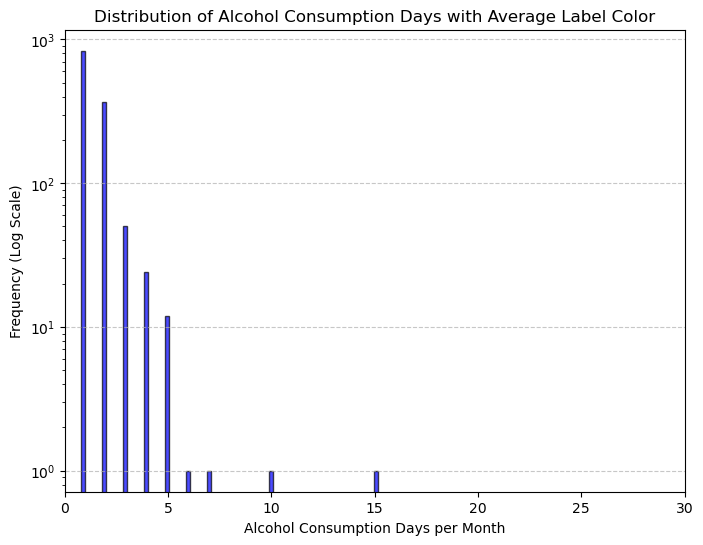

In [167]:

# Get the index for AVEDRNK2
avedrnk_index = features.index('AVEDRNK2')

# Balance the dataset
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]

# Extract AVEDRNK2 values and corresponding labels
avedrnk_values = X_train_balanced[:, avedrnk_index]
y_labels = Y_train_balanced

# Define bins for AVEDRNK2 (assuming typical values range up to around 20 drinks per day)
bins = np.linspace(0, 20, 100)  # 100 bins up to 20 for a more granular distribution

# Calculate the average label per bin
bin_indices = np.digitize(avedrnk_values, bins)
average_labels = []
for i in range(1, len(bins)):
    mask = bin_indices == i
    if mask.any():
        avg_label = y_labels[mask].mean()  # Calculate average label for the bin
        average_labels.append(avg_label)
    else:
        average_labels.append(0)  # Default to 0 if no samples in bin

# Plot the histogram with colored bins for AVEDRNK2
plt.figure(figsize=(8, 6))
for i in range(len(bins) - 1):
    bin_mask = (bin_indices == i + 1)
    bin_color = 'orange' if average_labels[i] >= 0.5 else 'blue'
    plt.hist(avedrnk_values[bin_mask], bins=[bins[i], bins[i + 1]], color=bin_color, edgecolor='black', alpha=0.7)

plt.xlabel('Average Drinks per Day')
plt.xlim(0, 20)
plt.ylabel('Frequency')
plt.title('Distribution of Average Drinks per Day with Average Label Color')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




[nan  1.  2. ...  2.  1.  1.]


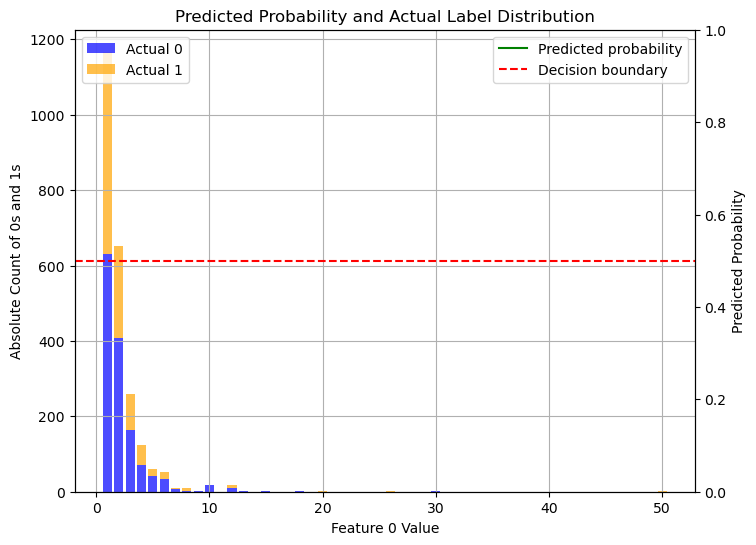

In [173]:

X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
features_list = [{'AVEDRNK2': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'range': (1, 76)}}]

analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=100, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= False, feature_index=0)

**ANALYSIS BMI**

In [52]:
bmi_values

array([        nan, 27.26371732, 31.00819156, ..., 24.40972222,
       24.95857988, 31.47038567])

In [120]:
X_train_balanced[:, avg_fruit_day_index]

array([1.258,   nan, 0.428, ..., 0.4  , 0.36 , 0.452])

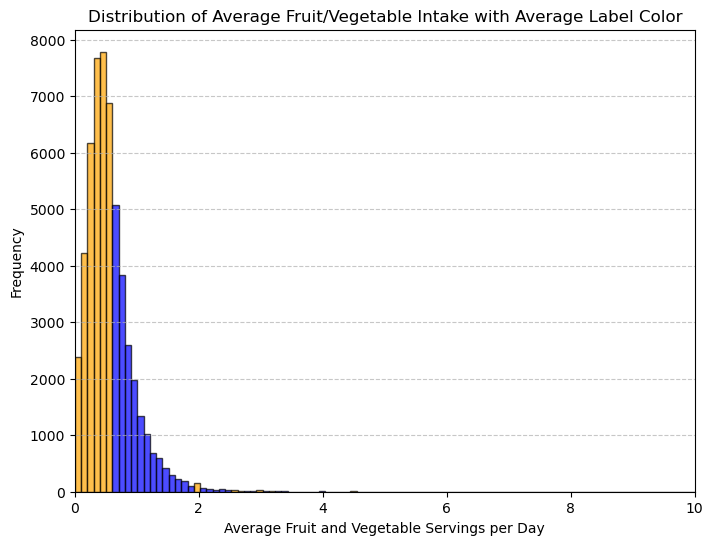

In [130]:
# Assuming `features` is a list of feature names
avg_fruit_day_index = features.index('AVG_FRUITS_VEGS')

# Balance the dataset
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]

# Extract avg_fruit_day values and corresponding labels
avg_fruit_day_values = X_train_balanced[:, avg_fruit_day_index]
y_labels = Y_train_balanced

# Define bins for avg_fruit_day
bins = np.linspace(0, 10, 100)  # 100 bins up to the max of avg_fruit_day

# Calculate the average label per bin
bin_indices = np.digitize(avg_fruit_day_values, bins)
average_labels = []
for i in range(1, len(bins)):
    mask = bin_indices == i
    if mask.any():
        avg_label = y_labels[mask].mean()  # Calculate average label for the bin
        average_labels.append(avg_label)
    else:
        average_labels.append(0)  # Default to 0 if no samples in bin

# Plot the histogram with colored bins for avg_fruit_day
plt.figure(figsize=(8, 6))
for i in range(len(bins) - 1):
    bin_mask = (bin_indices == i + 1)
    bin_color = 'orange' if average_labels[i] >= 0.5 else 'blue'
    plt.hist(avg_fruit_day_values[bin_mask], bins=[bins[i], bins[i + 1]], color=bin_color, edgecolor='black', alpha=0.7)

plt.xlabel('Average Fruit and Vegetable Servings per Day')
plt.xlim(0, 10)

plt.ylabel('Frequency')
plt.title('Distribution of Average Fruit/Vegetable Intake with Average Label Color')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


[1 0 0 ... 0 1 1]


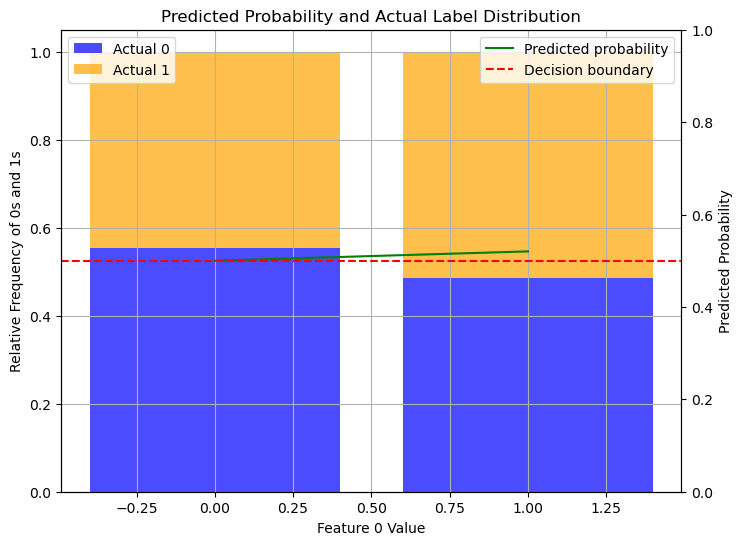

In [141]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
features_list = [{ 'AVG_FRUITS_VEGS': {'type': 'binary', 'missing_values': [np.nan]}
    }]

analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=100, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative= True, feature_index=0)

[0.21  0.486 0.6   ... 0.228 0.514 0.98 ]


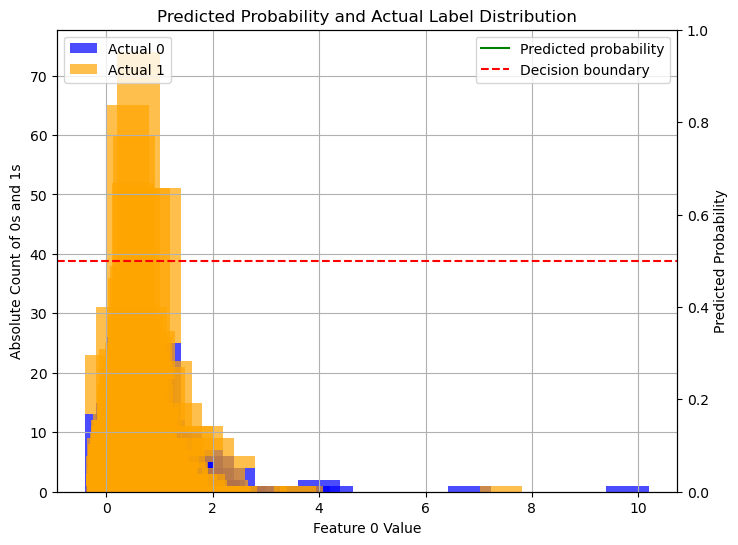

In [127]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
features_list = [{ 'AVG_FRUITS_VEGS': {'type': 'numeric', 'missing_values': [np.nan], 'range': (0, 9999)}
    }]

analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative=False, feature_index=0)

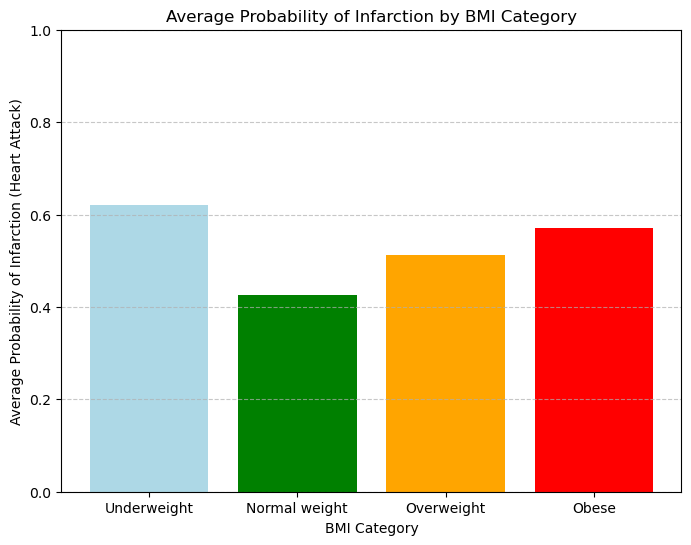

In [75]:
# Define BMI bins and labels
bmi_bins = [0, 16, 24.9, 29.9, np.inf]  # Define cutoffs for underweight, normal, overweight, obese
bmi_labels = ["Underweight", "Normal weight", "Overweight", "Obese"]

# Digitize the BMI values into categories
bmi_categories = np.digitize(bmi_values, bins=bmi_bins)

# Calculate the average label (probability of infarction) for each BMI category
category_means = []
for i in range(1, len(bmi_bins)):
    mask = bmi_categories == i
    if np.any(mask):  # Check if there are values in this bin
        avg_label = y_labels[mask].mean()  # Calculate the average label for this bin
        category_means.append(avg_label)
    else:
        category_means.append(0)  # If no data in bin, set average to 0

# Plot the average label by BMI category
plt.figure(figsize=(8, 6))
plt.bar(bmi_labels, category_means, color=['lightblue', 'green', 'orange', 'red'])
plt.xlabel('BMI Category')
plt.ylabel('Average Probability of Infarction (Heart Attack)')
plt.title('Average Probability of Infarction by BMI Category')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

[1. 0. 1. ... 1. 1. 1.]


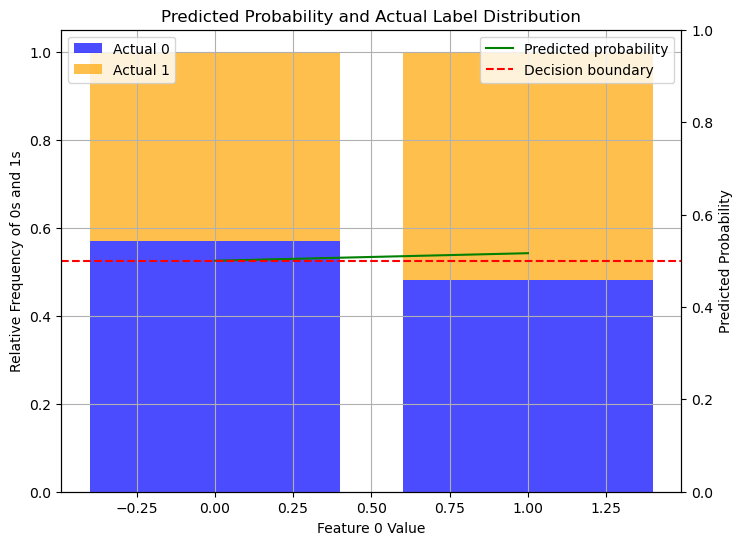

In [111]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
features_list = [{ 'BMI': {'type': 'numeric', 'missing_values': [np.nan], 'range': (1, 4)}
    }]

analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative=True, feature_index=0)

0.0
[0. 5. 7. ... 5. 0. 2.]
[ 0.  4. 30. ...  2.  0.  0.]


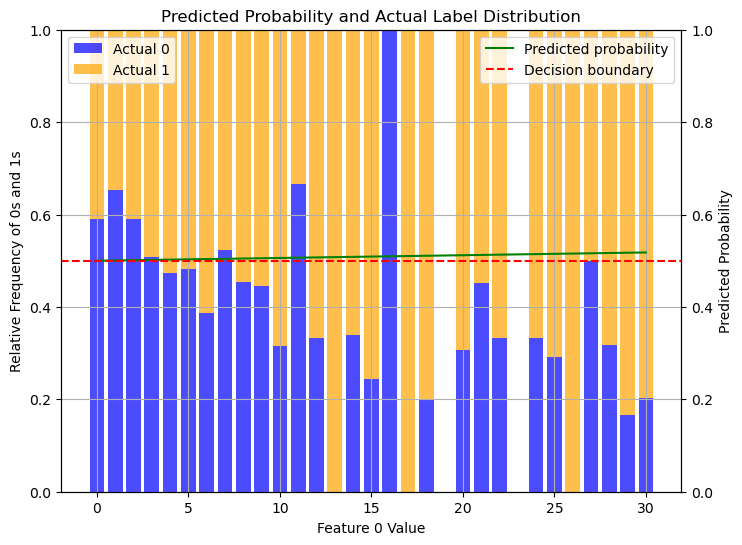

In [8]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
features_list = [{'PHYSHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)}}]
N = Y_train_balanced.shape[0]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=50, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative=True, feature_index=0)

{'USEEQUIP': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 1 0 ... 1 0 0]


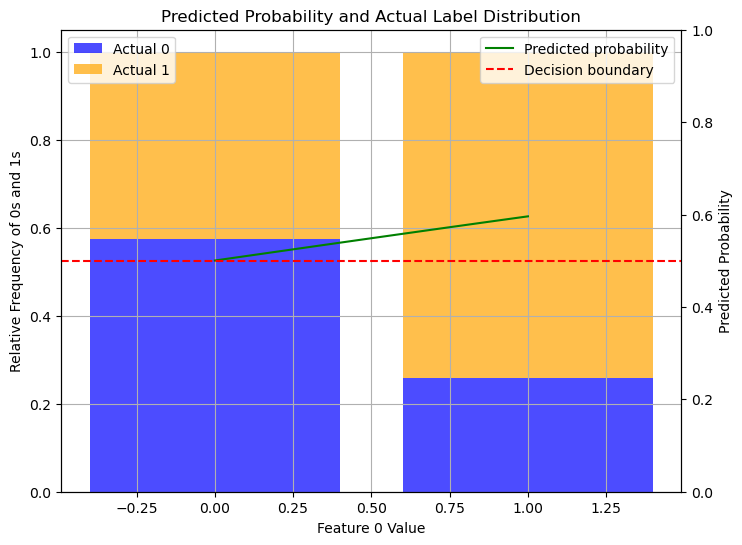

{'BLIND': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


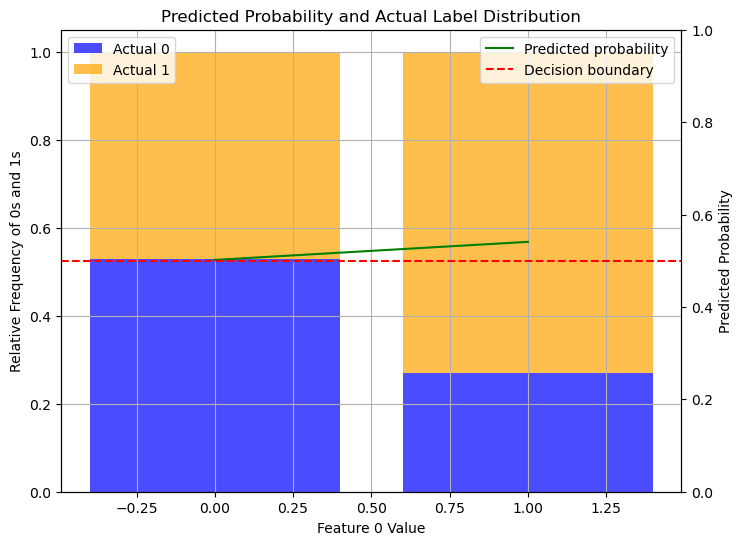

{'DECIDE': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


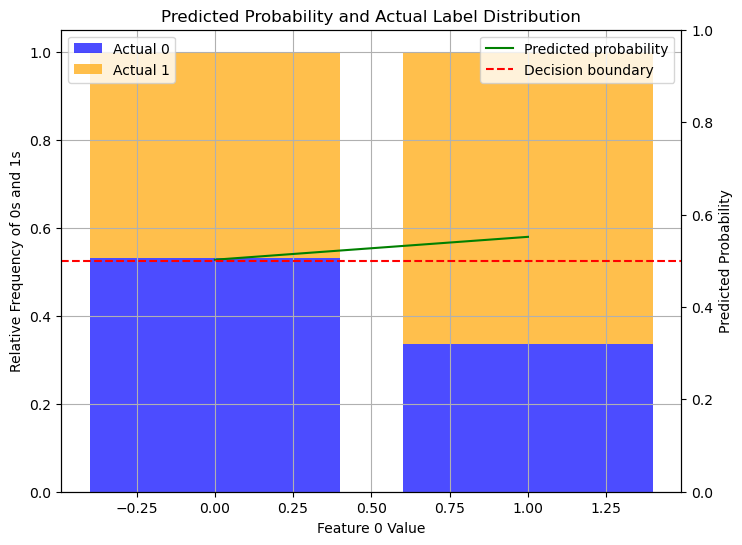

{'DIFFWALK': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 1 ... 1 0 0]


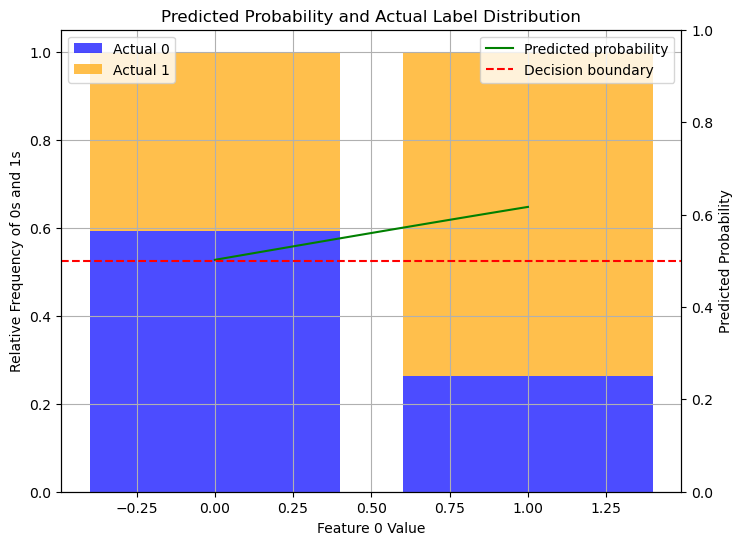

{'DIFFDRES': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[1 0 0 ... 0 0 0]


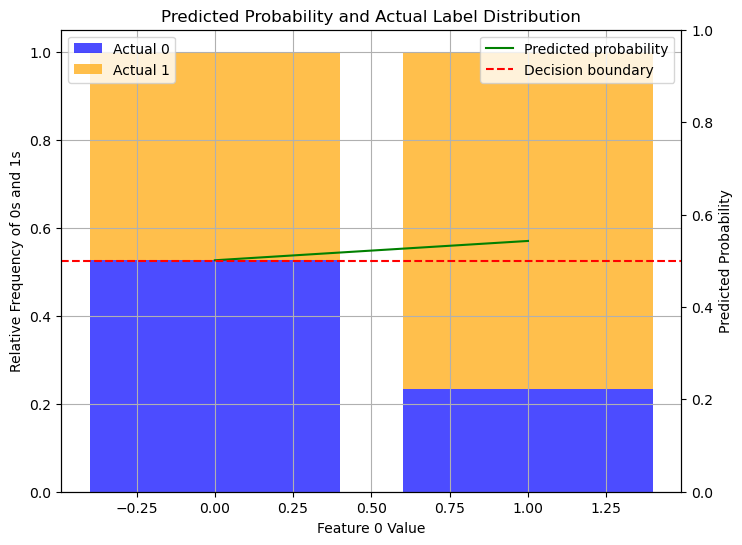

{'DIFFALON': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 1 0 0]


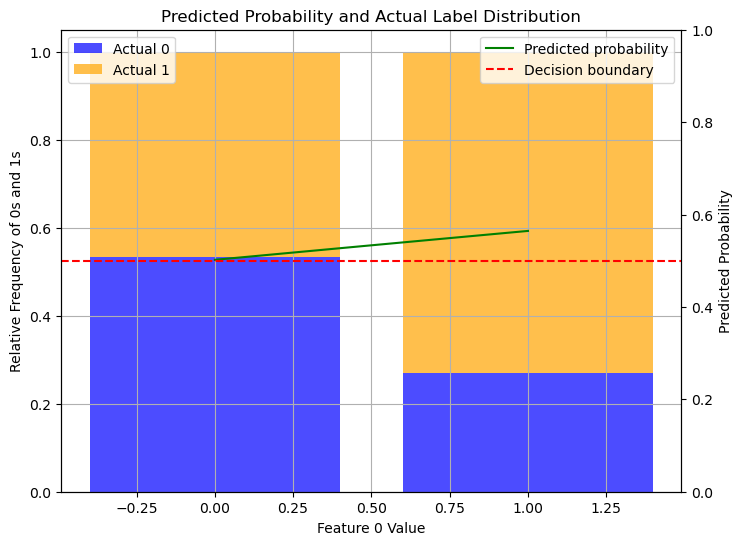

In [ ]:
features_list = [
    {'BPMEDS': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'TOLDHI2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'DIABETE3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'QLACTLM2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'EXERANY2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'SMOKE100': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'HAVARTH3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'SEX': {'type': 'binary', 'missing_values': [np.nan]}},
    {'BPHIGH4': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'USEEQUIP': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'BLIND': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'DECIDE': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'DIFFWALK': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'DIFFDRES': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'DIFFALON': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'ALCDAY5': {'type': 'binary', 'missing_values': [np.nan]}},
    {'CHECKUP1': {'type': 'binary', 'missing_values': [np.nan]}},
    {'STRENGTH': {'type': 'binary', 'missing_values': [np.nan]}},
    {'CHECKUP1': {'type': 'binary', 'missing_values': [np.nan]}},
    {'AVG_FRUITS_VEGS': {'type': 'binary', 'missing_values': [np.nan]}}



    # Categorical variable
    {'_RACEGR3': {
        'type': 'categorical',
        'missing_values': [9, np.nan],
        'categories': [1, 2, 3, 4, 5]
    }},

    # Numeric variables
    {'BMI': {'type': 'numeric', 'missing_values': [7777, 9999, np.nan], 'range': (1,4)}},
    {'MENTHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)}},
    {'PHYSHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)}},
    {'_AGEG5YR': {'type': 'numeric', 'missing_values': [14, np.nan], 'range': (1, 13)}}
]


X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
for feature in features_list:
    print(feature)
    analyze_correlation(feature, X_train_balanced, Y_train_balanced,
                        max_iters=100, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N)

In [47]:
features_list = [
    {'BPMEDS': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'TOLDHI2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'DIABETE3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'QLACTLM2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'EXERANY2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'SMOKE100': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'HAVARTH3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},
    {'SEX': {'type': 'binary', 'missing_values': [np.nan]}},
    {'BPHIGH4': {'type': 'binary', 'missing_values': [7, 9, np.nan]}},

    # Categorical variable
    {'_RACEGR3': {
        'type': 'categorical',
        'missing_values': [9, np.nan],
        'categories': [1, 2, 3, 4, 5]
    }},

    # Numeric variables
    {'SMOKDAY2': {'type': 'numeric', 'missing_values': [7, 9, np.nan], 'map_value': {3: 0}, 'range': (1, 3)}},
    {'ALCDAY5': {'type': 'numeric', 'missing_values': [777, 999, np.nan], 'map_value': {888: 0}, 'range': (0, 431)}},
    {'AVEDRNK2': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'range': (1, 76)}},
    {'BMI': {'type': 'numeric', 'missing_values': [7777, 9999, np.nan], 'range': (0, 100)}},
    {'POORHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)}},
    {'CHECKUP1': {'type': 'numeric', 'missing_values': [7, 9, np.nan], 'map_value': {8: 5}, 'range': (1, 5)}},
    {'STRENGTH': {'type': 'numeric', 'missing_values': [777, 999, np.nan], 'map_value': {888: 0}, 'range': (0, 431)}},
    {'EXEROFT1': {'type': 'numeric', 'missing_values': [777, 999, np.nan], 'range': (0, 431)}},
    {'MENTHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)}},
    {'AVG_FRUITS_VEGS': {'type': 'numeric', 'missing_values': [np.nan], 'range': (0, 9999)}},
    {'PHYSHLTH': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'map_value': {88: 0}, 'range': (1, 30)}},
    {'JOINPAIN': {'type': 'numeric', 'missing_values': [77, 99, np.nan], 'range': (0, 10)}},
    {'_AGEG5YR': {'type': 'numeric', 'missing_values': [14, np.nan], 'range': (1, 13)}}
]

{'BPMEDS': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 1 1 ... 1 0 1]


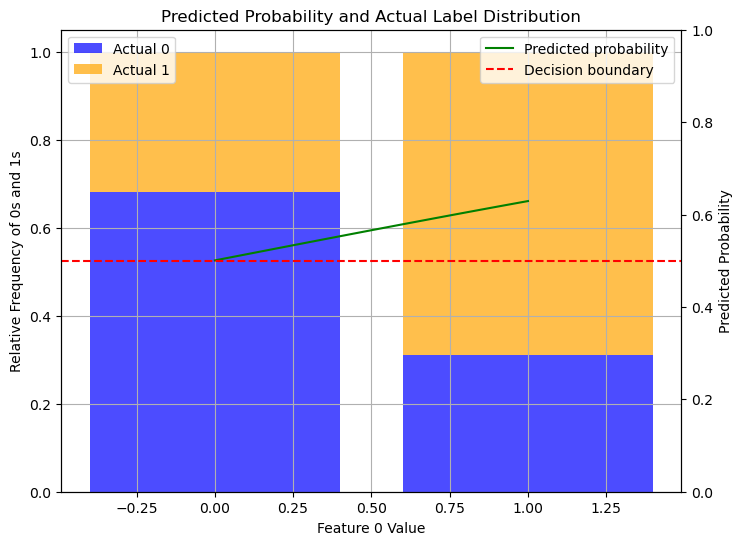

{'TOLDHI2': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 1]


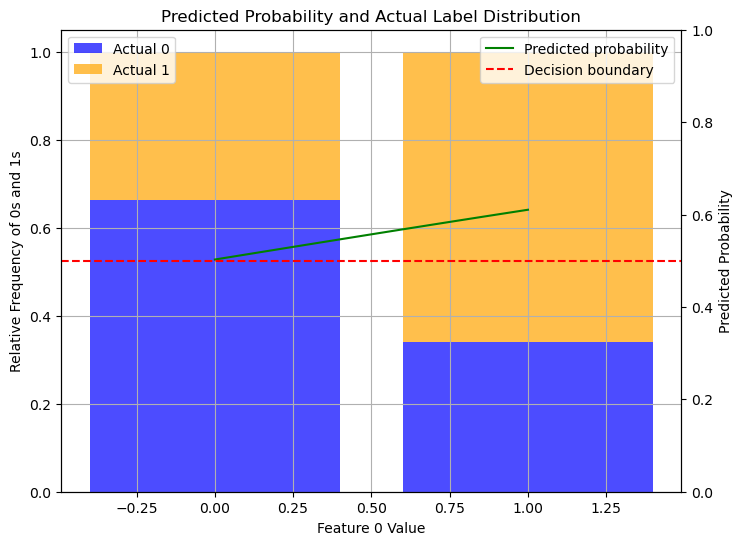

{'DIABETE3': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 1 0]


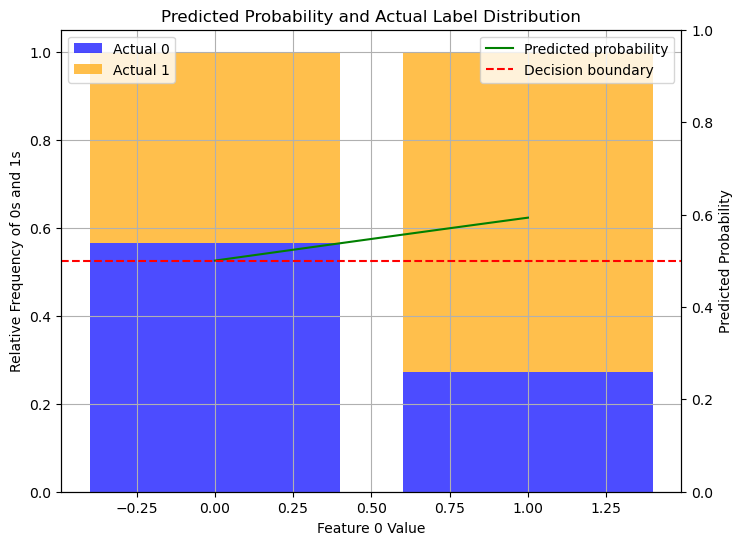

{'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[1 1 1 ... 1 1 1]


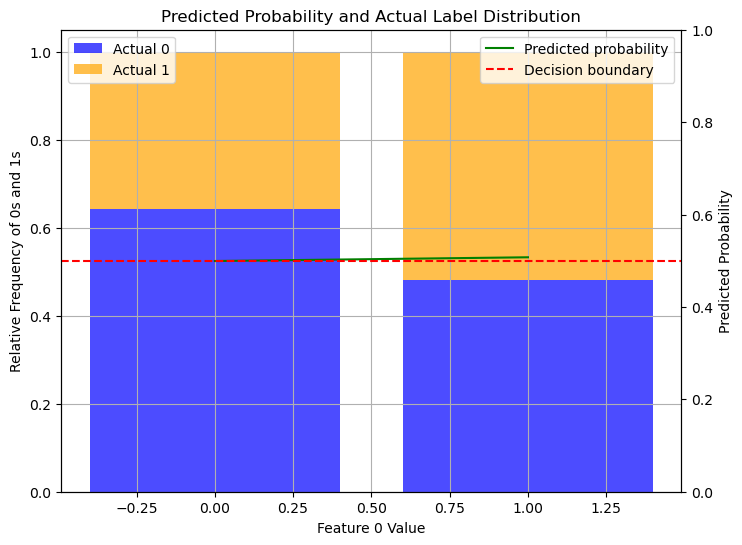

{'QLACTLM2': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


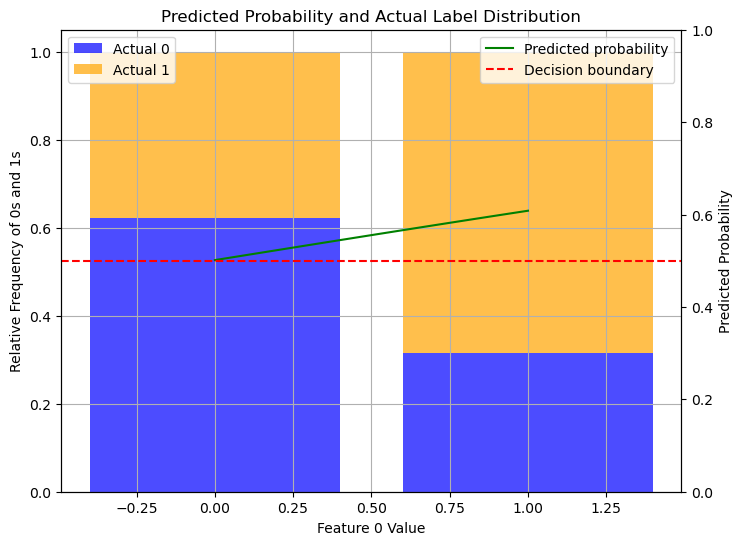

{'EXERANY2': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[1 1 1 ... 1 0 0]


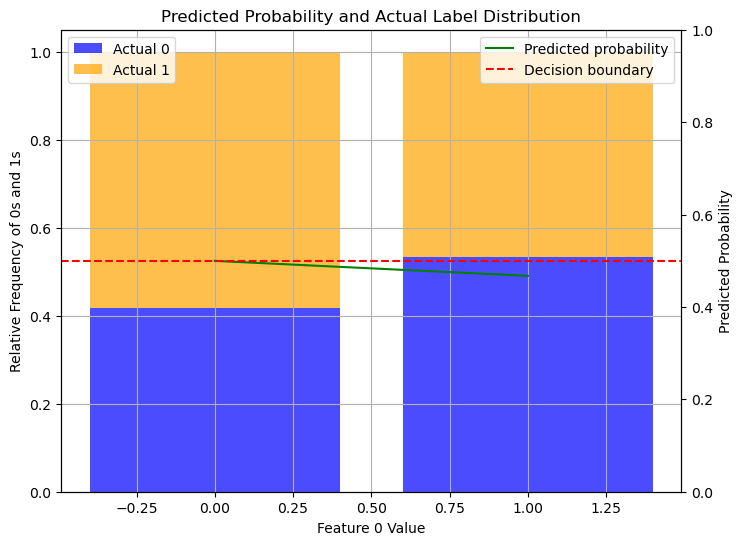

{'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 1 0 ... 0 0 0]


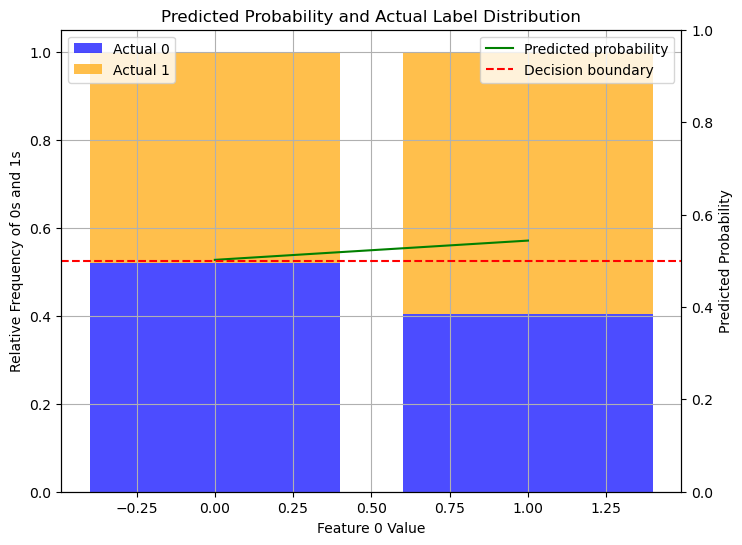

{'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 0]


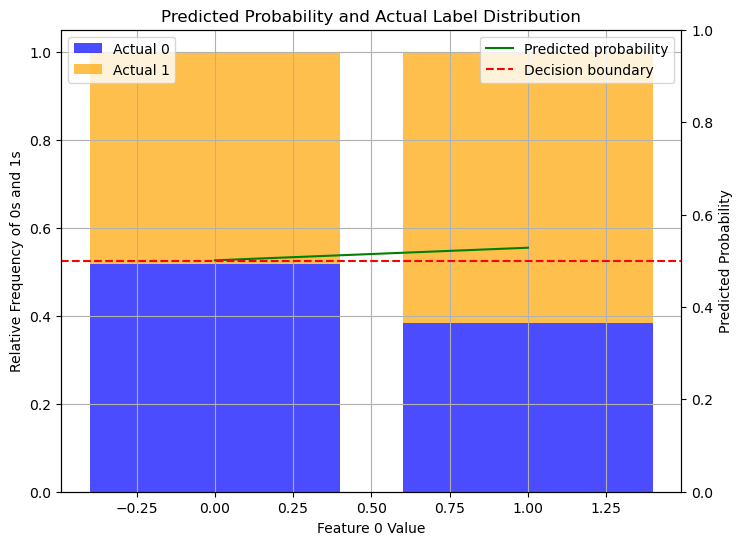

{'SMOKE100': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 1 0 ... 1 1 1]


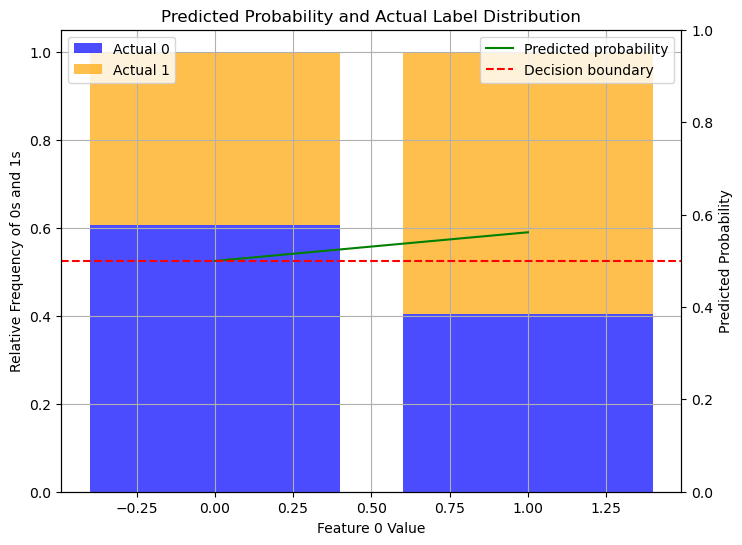

{'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 0 1]


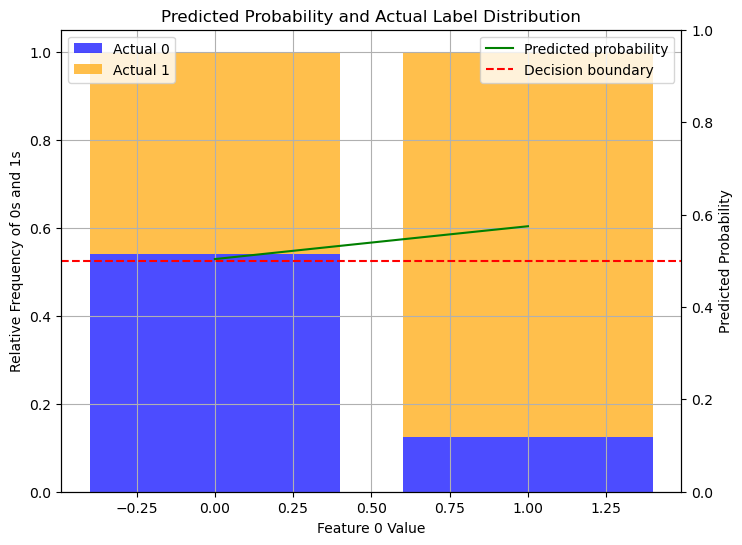

{'HAVARTH3': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 1 1 ... 0 0 1]


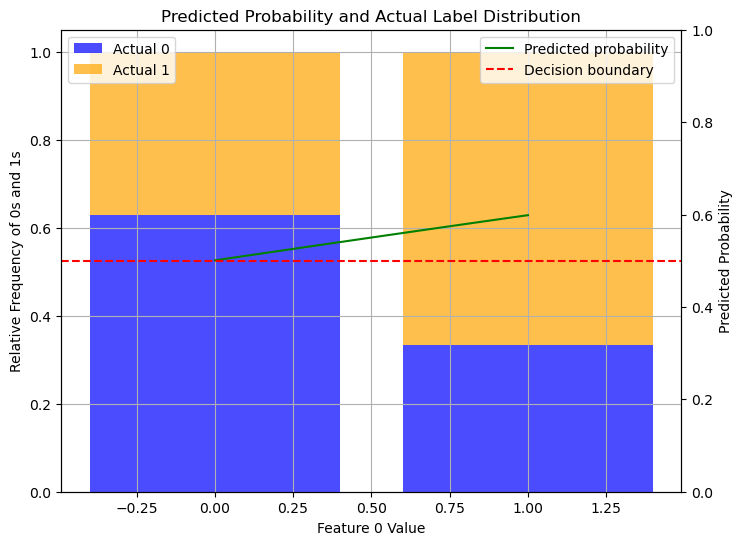

{'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 1 ... 0 1 0]


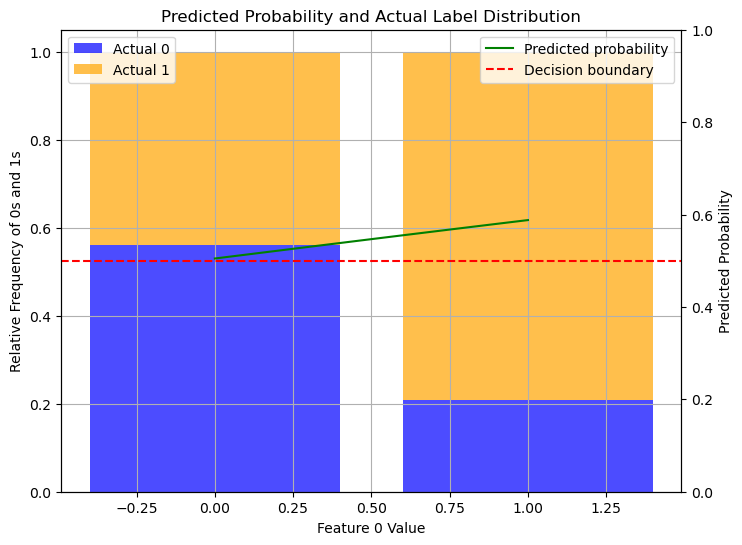

{'SEX': {'type': 'binary', 'missing_values': [nan]}}
[0 1 1 ... 0 0 1]


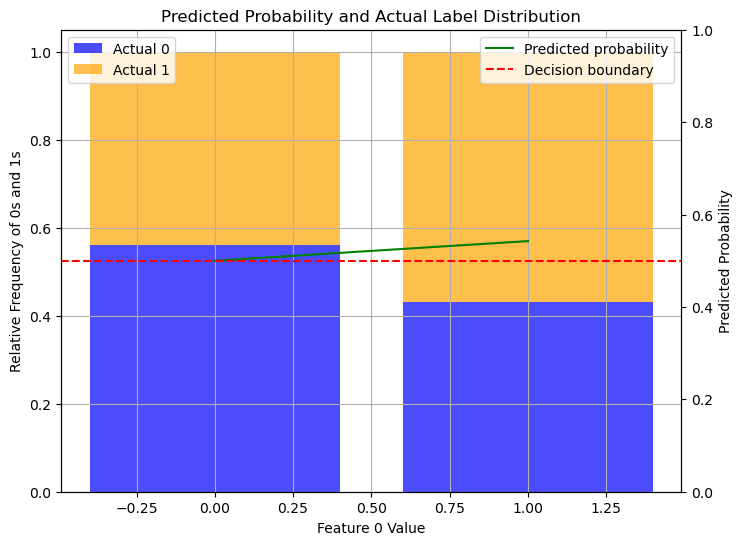

{'BPHIGH4': {'type': 'binary', 'missing_values': [7, 9, nan]}}
[0 0 0 ... 0 1 0]


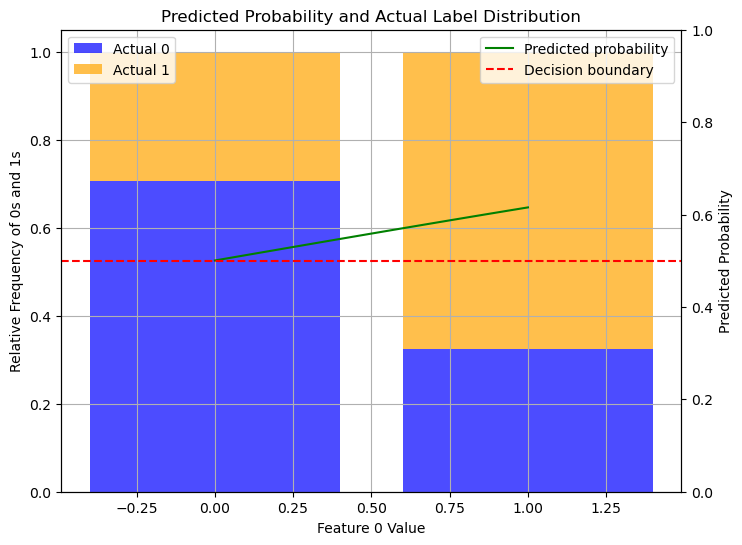

{'_RACEGR3': {'type': 'categorical', 'missing_values': [9, nan], 'categories': [1, 2, 3, 4, 5]}}
[0 0 0 ... 0 0 1]


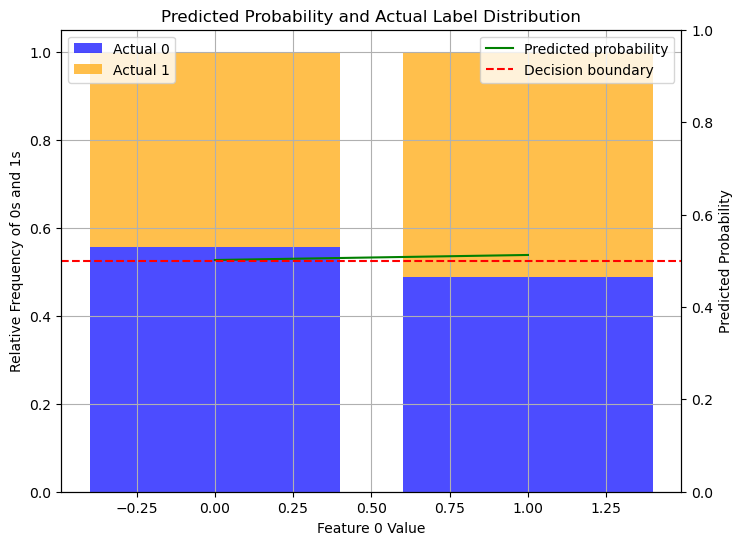

{'SMOKDAY2': {'type': 'numeric', 'missing_values': [7, 9, nan], 'map_value': {3: 0}, 'range': (1, 3)}}
[ 1. nan  0. ... nan nan  0.]


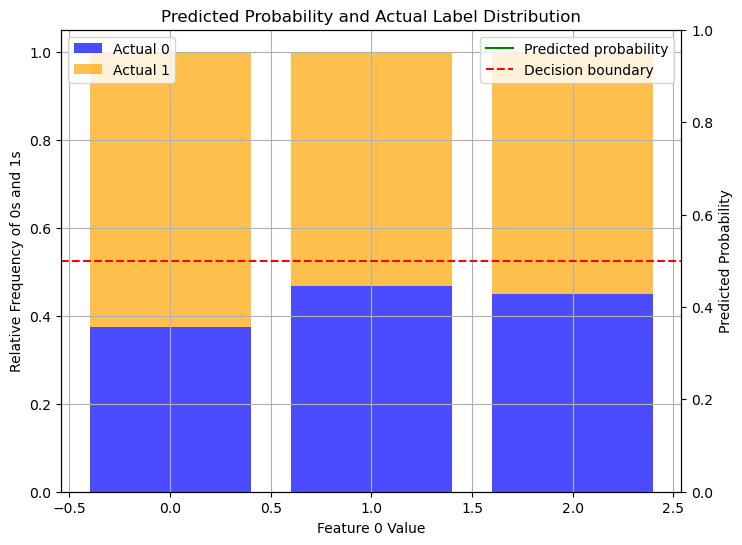

{'ALCDAY5': {'type': 'numeric', 'missing_values': [777, 999, nan], 'map_value': {888: 0}, 'range': (0, 431)}}
[ 0.     0.     4.    ... 26.07   0.    13.035]


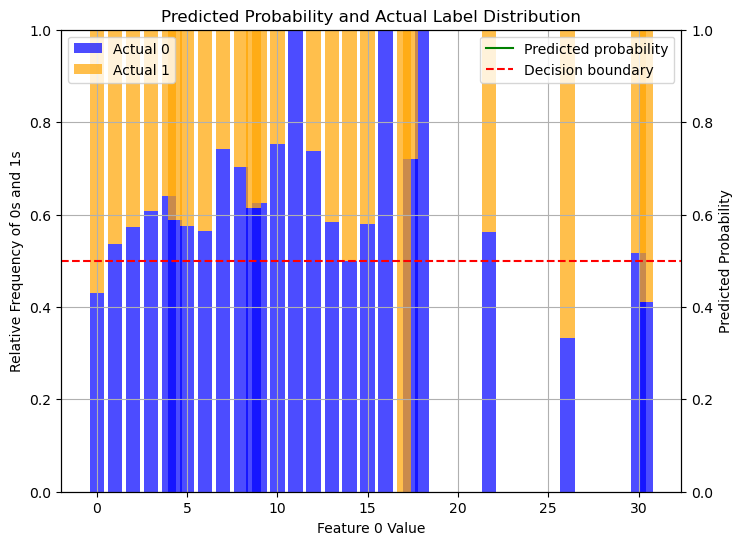

{'AVEDRNK2': {'type': 'numeric', 'missing_values': [77, 99, nan], 'range': (1, 76)}}
[nan  2.  3. ... nan nan  3.]


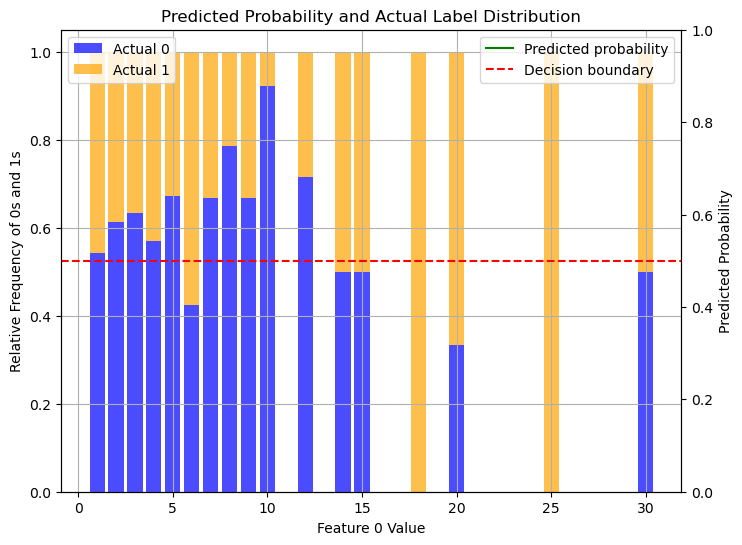

{'BMI': {'type': 'numeric', 'missing_values': [7777, 9999, nan], 'range': (0, 100)}}
[20.34143519 24.20798898 53.89208984 ...         nan 25.67567568
 24.40487998]


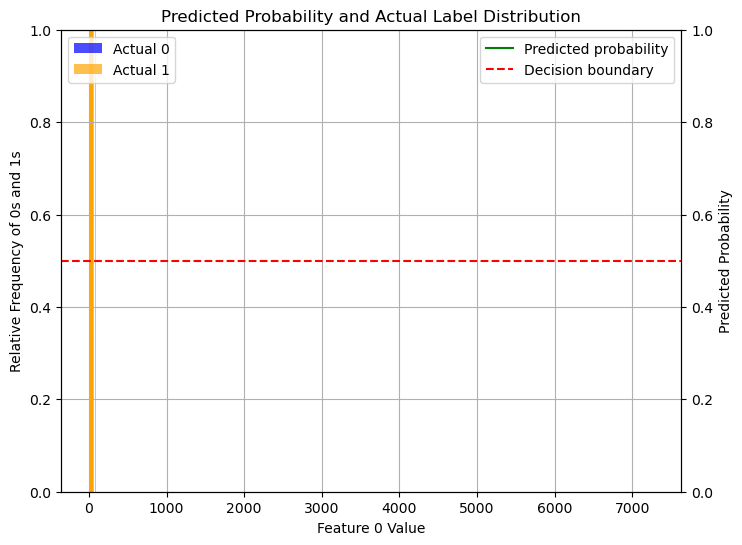

{'POORHLTH': {'type': 'numeric', 'missing_values': [77, 99, nan], 'map_value': {88: 0}, 'range': (1, 30)}}
[ 5. nan nan ...  0. nan  0.]


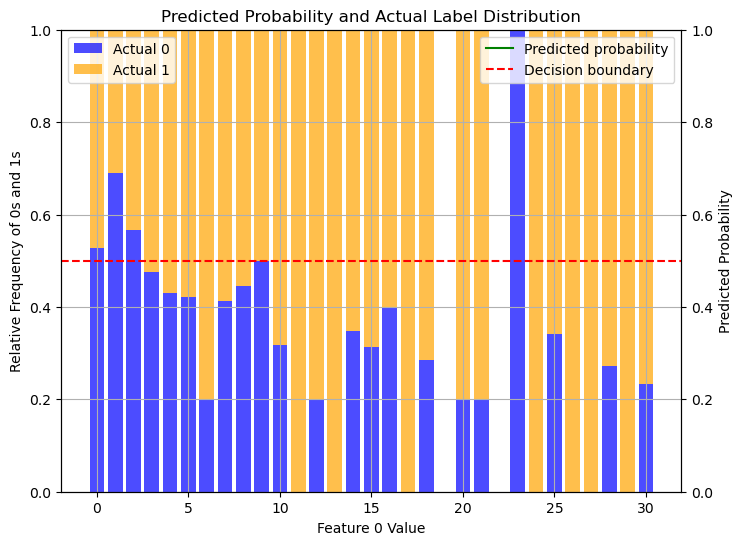

{'CHECKUP1': {'type': 'numeric', 'missing_values': [7, 9, nan], 'map_value': {8: 5}, 'range': (1, 5)}}
[1. 1. 1. ... 2. 1. 1.]


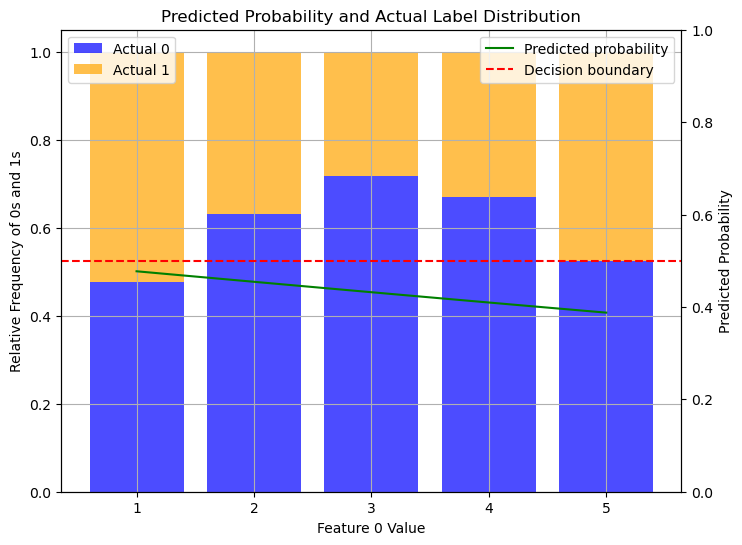

{'STRENGTH': {'type': 'numeric', 'missing_values': [777, 999, nan], 'map_value': {888: 0}, 'range': (0, 431)}}
[0.   0.   8.69 ... 0.   3.   0.  ]


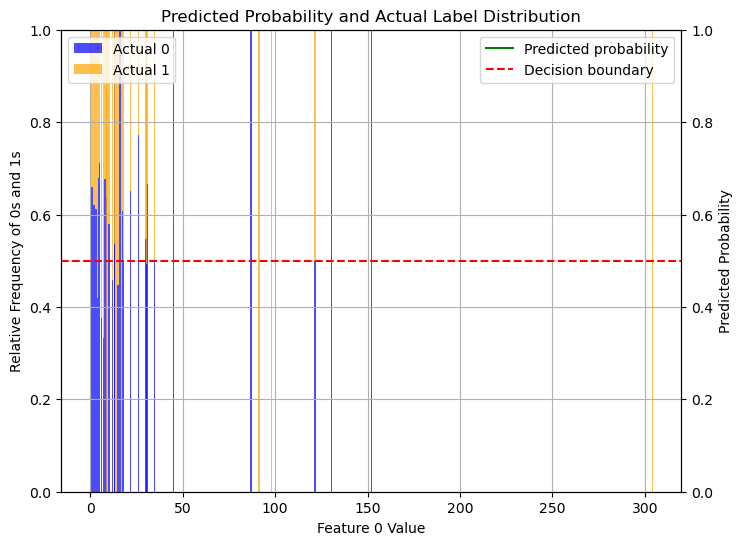

{'EXEROFT1': {'type': 'numeric', 'missing_values': [777, 999, nan], 'range': (0, 431)}}
[ 13.035   0.    430.155 ...   6.      8.69   13.035]


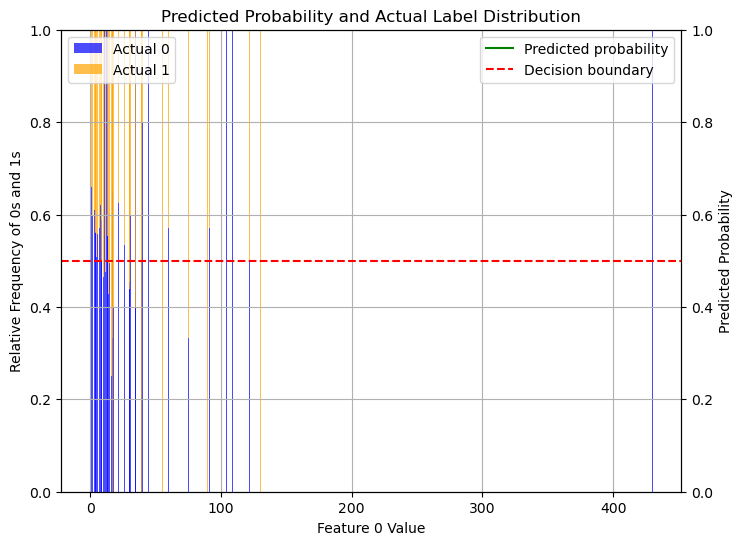

{'MENTHLTH': {'type': 'numeric', 'missing_values': [77, 99, nan], 'map_value': {88: 0}, 'range': (1, 30)}}
[ 0.  0. 30. ...  0.  0.  0.]


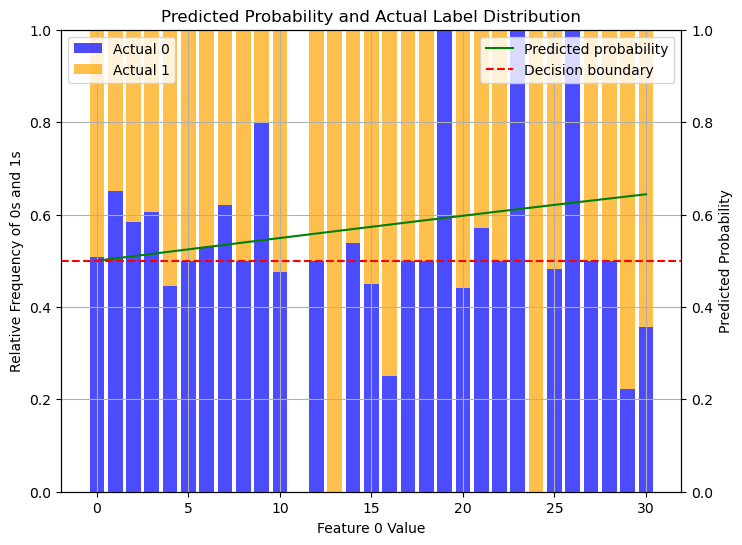

{'AVG_FRUITS_VEGS': {'type': 'numeric', 'missing_values': [nan], 'range': (0, 9999)}}
[0.45  0.614   nan ... 0.716 0.488 0.178]


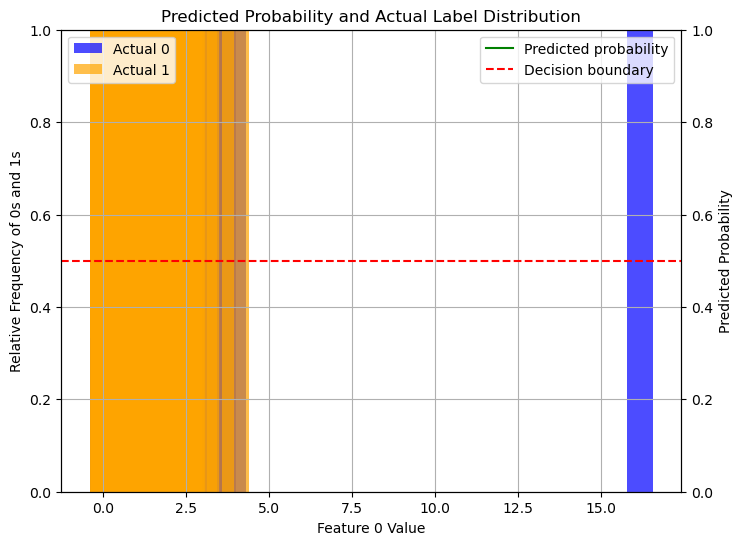

{'PHYSHLTH': {'type': 'numeric', 'missing_values': [77, 99, nan], 'map_value': {88: 0}, 'range': (1, 30)}}
[ 3.  0.  0. ...  0. 30.  3.]


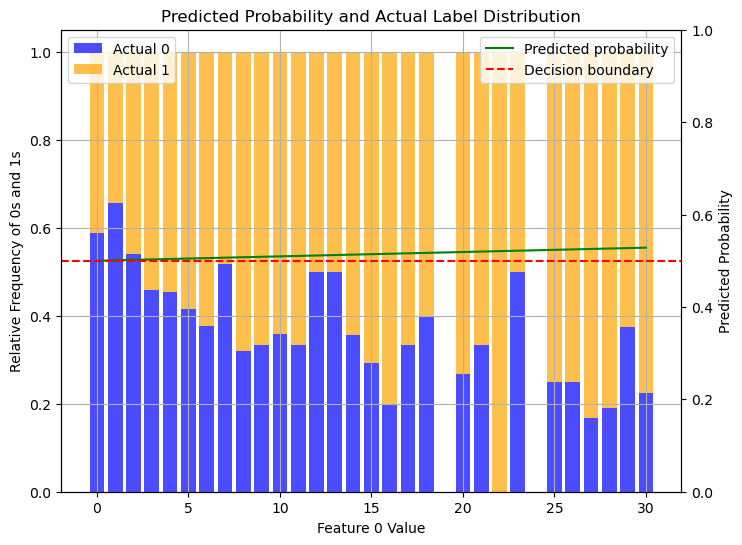

{'JOINPAIN': {'type': 'numeric', 'missing_values': [77, 99, nan], 'range': (0, 10)}}
[10. nan  0. ...  4. nan nan]


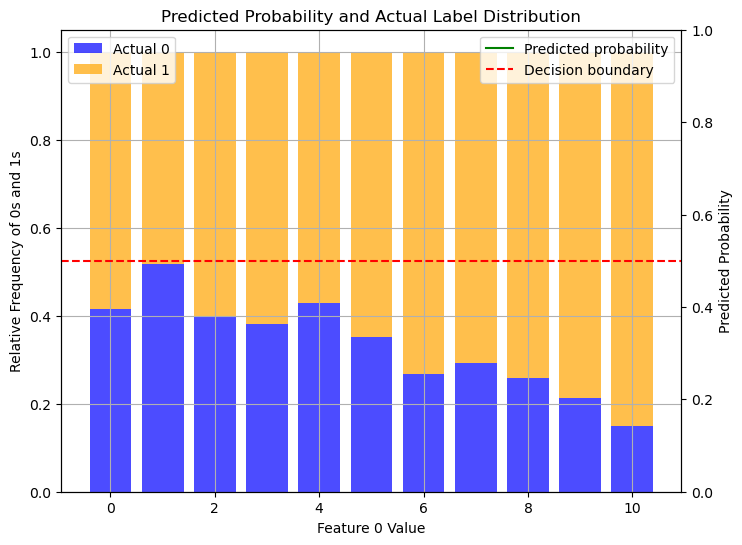

{'_AGEG5YR': {'type': 'numeric', 'missing_values': [14, nan], 'range': (1, 13)}}
[ 9. 10. 13. ... 13.  9.  4.]


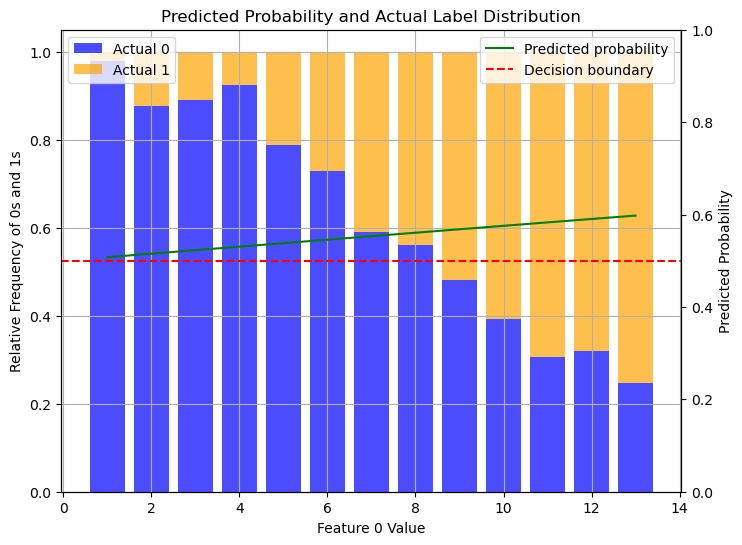

In [49]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
for feature in features_list:
    print(feature)
    analyze_correlation(feature, X_train_balanced, Y_train_balanced,
                        max_iters=100, gamma=0.1,reg_norm='', prob_threshold=0.5, batch_size = N)

**ANALYSIS 'MENTHLTH'**


In [32]:
features_list = [
  
    
    # Numeric variables with ranges
    {'MENTHLTH': {
        'type': 'numeric', 
        'missing_values': [77, 99, np.nan],
        'range': (1, 30),  
        'map_value': {88: 0}
    }
    }
]   

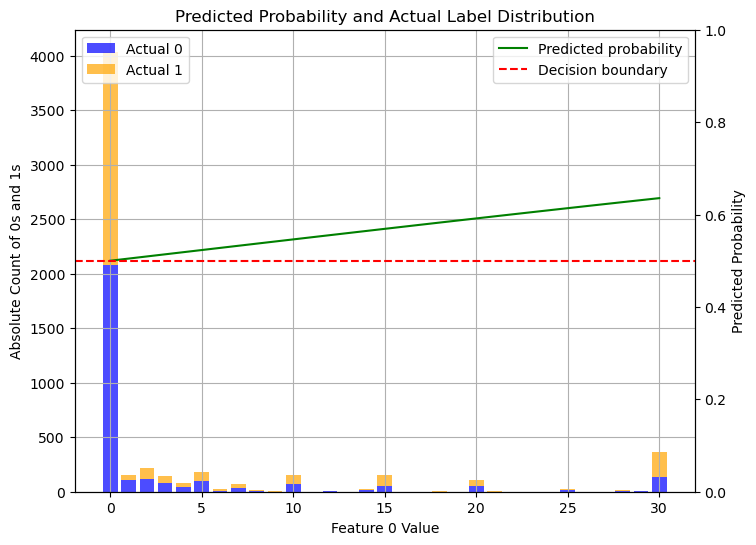

In [34]:

index_MENT = features.index('MENTHLTH')
X_train_balanced[:30, index_MENT]
analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                        max_iters=100, gamma=0.01,reg_norm='', prob_threshold=0.5, batch_size = N,
                        relative=False)


**ANALYSIS RACE**
- White higher prob that rest of groups
- Black only same prob as rest
- Other race only, multiracial, hispanic: less

In [36]:

index_RACE = features.index('_RACEGR3')
X_train_balanced[:30, index_RACE]

array([1., 1., 5., 1., 1., 1., 5., 2., 1., 1., 1., 1., 1., 3., 5., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 5., 1.])

[1 1 1 ... 1 1 0]


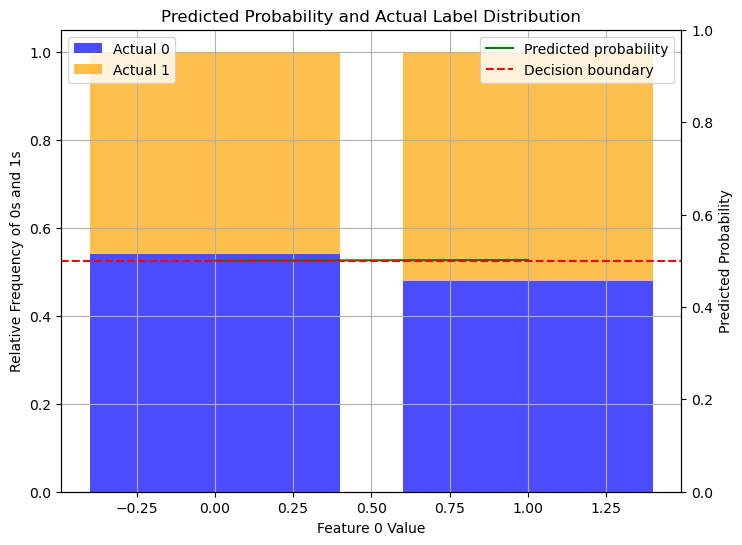

In [44]:
#_RACEG21
features_list = [ {'_RACEG21': {
        'type': 'binary', 
        'missing_values': [9, np.nan]
    }}]

analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=100, gamma=0.01,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative=True, feature_index=0)

[1 1 0 ... 0 0 1]


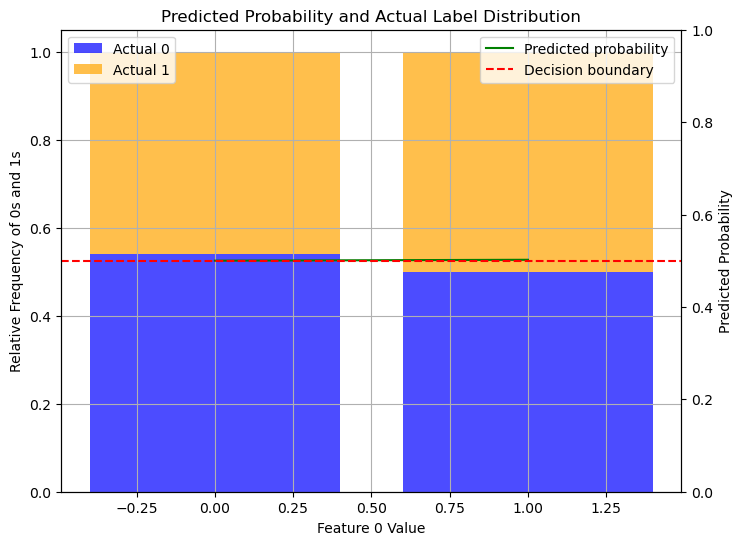

[0 0 0 ... 0 0 0]


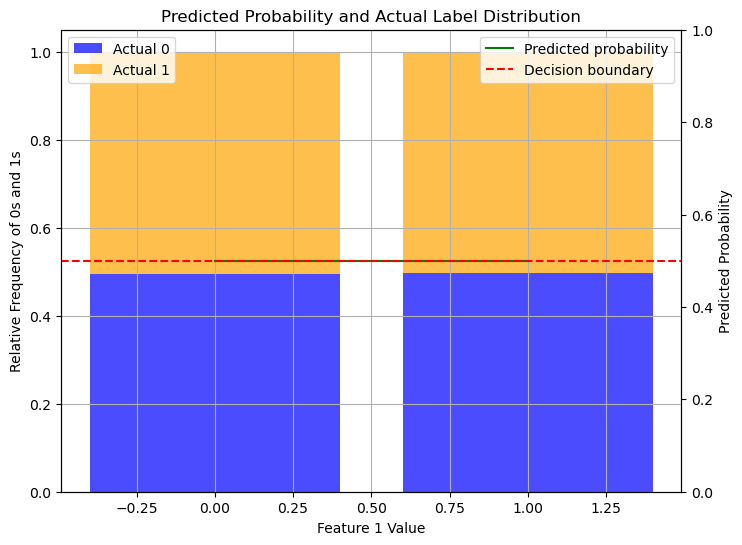

[0 0 0 ... 0 0 1]


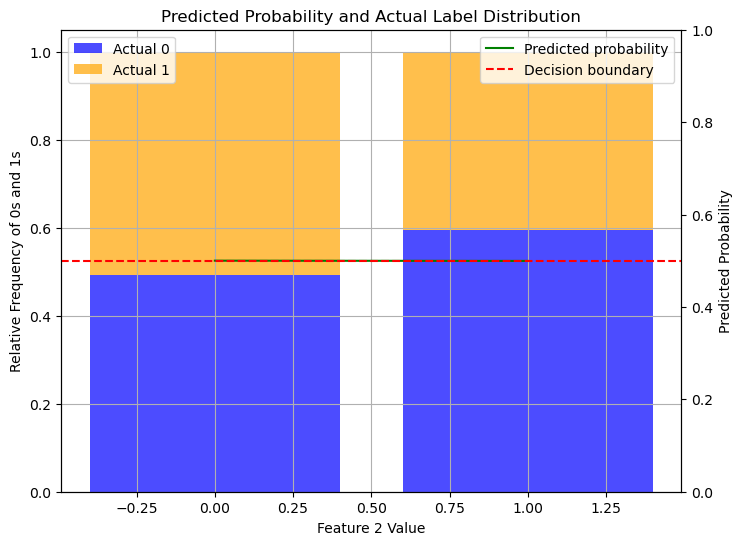

[0 0 0 ... 1 0 0]


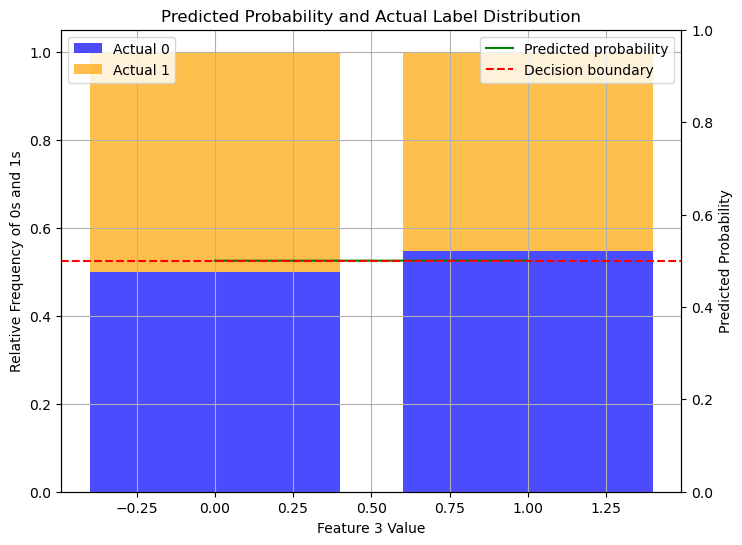

[0 0 0 ... 0 0 0]


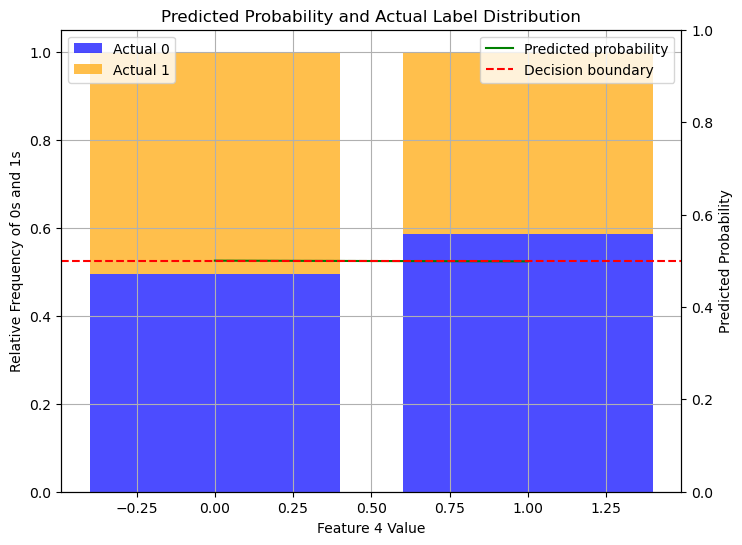

In [42]:
features_list = [ {'_RACEGR3': {
        'type': 'categorical', 
        'missing_values': [9, np.nan],
        'categories': [1, 2, 3, 4, 5]
    }}]
for index in range(0,5):
    analyze_correlation(features_list[0], X_train_balanced, Y_train_balanced,
                            max_iters=100, gamma=0.01,reg_norm='', prob_threshold=0.5, batch_size = N,
                            relative=True, feature_index=index)

[[11.]
 [11.]
 [13.]
 ...
 [10.]
 [11.]
 [ 3.]]
[0.00618844]
[0.01113943]
[0.01510229]
[0.0182765]
[0.02082096]
[0.02286215]
[0.02450074]
[0.02581693]
[0.0268747]
[0.02772516]
[0.02840919]
[0.02895952]
[0.0294024]
[0.02975888]
[0.03004586]
[0.03027692]
[0.03046299]
[0.03061283]
[0.0307335]
[0.0308307]
[0.03090899]
[0.03097205]
[0.03102284]
[0.03106376]
[0.03109672]
[0.03112327]
[0.03114466]
[0.03116189]
[0.03117577]
[0.03118696]
[0.03119597]
[0.03120322]
[0.03120907]
[0.03121378]
[0.03121757]
[0.03122063]
[0.03122309]
[0.03122508]
[0.03122668]
[0.03122796]
[0.031229]
[0.03122984]
[0.03123051]
[0.03123105]
[0.03123149]
[0.03123184]
[0.03123212]
[0.03123235]
[0.03123254]
[0.03123269]


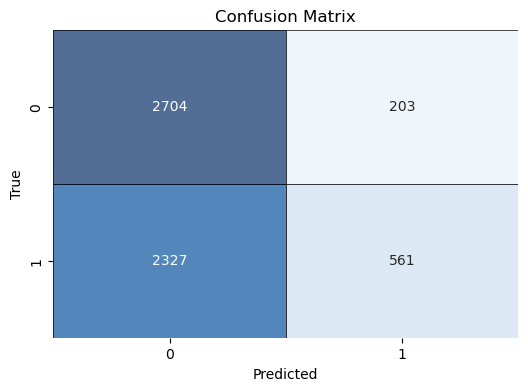

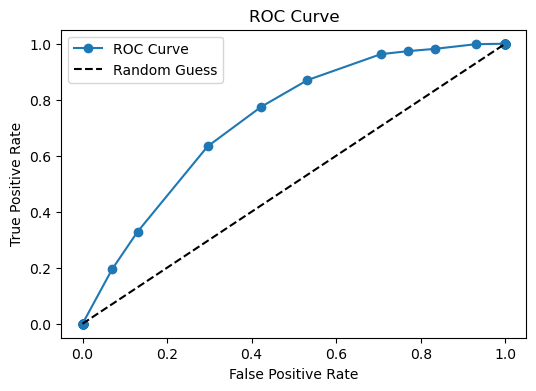

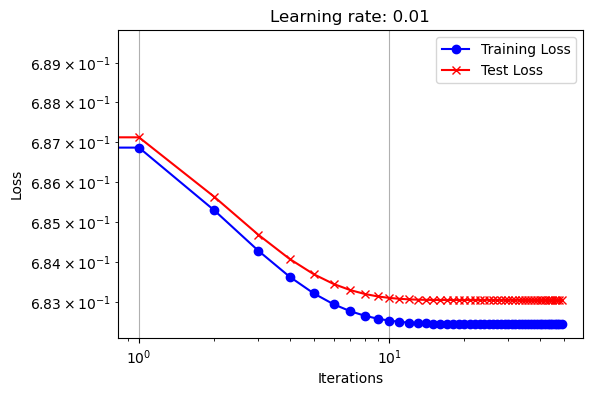

[ 1.          1.12121212  1.24242424  1.36363636  1.48484848  1.60606061
  1.72727273  1.84848485  1.96969697  2.09090909  2.21212121  2.33333333
  2.45454545  2.57575758  2.6969697   2.81818182  2.93939394  3.06060606
  3.18181818  3.3030303   3.42424242  3.54545455  3.66666667  3.78787879
  3.90909091  4.03030303  4.15151515  4.27272727  4.39393939  4.51515152
  4.63636364  4.75757576  4.87878788  5.          5.12121212  5.24242424
  5.36363636  5.48484848  5.60606061  5.72727273  5.84848485  5.96969697
  6.09090909  6.21212121  6.33333333  6.45454545  6.57575758  6.6969697
  6.81818182  6.93939394  7.06060606  7.18181818  7.3030303   7.42424242
  7.54545455  7.66666667  7.78787879  7.90909091  8.03030303  8.15151515
  8.27272727  8.39393939  8.51515152  8.63636364  8.75757576  8.87878788
  9.          9.12121212  9.24242424  9.36363636  9.48484848  9.60606061
  9.72727273  9.84848485  9.96969697 10.09090909 10.21212121 10.33333333
 10.45454545 10.57575758 10.6969697  10.81818182 10.

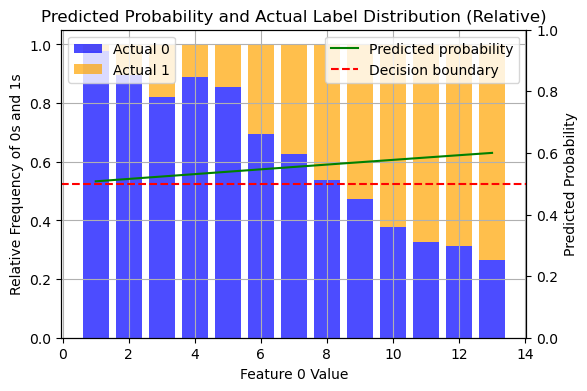

In [14]:


X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
features_dict = {'_AGEG5YR': {'type': 'numeric', 'missing_values': [14, np.nan], 'range': (1, 13)}}

X_train_transformed = transform_features_column_median(X_train_balanced, features_dict, features)
print(X_train_transformed)
F1_score = one_run_logistic_regression(X_train_transformed, Y_train_balanced, 
                                               max_iters=50, gamma=0.01, reg_norm='l2', 
                                               prob_threshold=0.6, batch_size=N, plot=True)

[[0 0]
 [1 0]
 [1 0]
 ...
 [0 0]
 [0 0]
 [0 0]]
[0.00027886 0.        ]
[0.00055737 0.        ]
[0.00083552 0.        ]
[0.00111332 0.        ]
[0.00139077 0.        ]
[0.00166787 0.        ]
[0.00194461 0.        ]
[0.002221 0.      ]
[0.00249704 0.        ]
[0.00277273 0.        ]
[0.00304807 0.        ]
[0.00332307 0.        ]
[0.00359771 0.        ]
[0.003872 0.      ]
[0.00414595 0.        ]
[0.00441954 0.        ]
[0.0046928 0.       ]
[0.0049657 0.       ]
[0.00523826 0.        ]
[0.00551047 0.        ]
[0.00578233 0.        ]
[0.00605385 0.        ]
[0.00632503 0.        ]
[0.00659586 0.        ]
[0.00686635 0.        ]
[0.00713649 0.        ]
[0.00740629 0.        ]
[0.00767575 0.        ]
[0.00794487 0.        ]
[0.00821364 0.        ]
[0.00848207 0.        ]
[0.00875017 0.        ]
[0.00901792 0.        ]
[0.00928533 0.        ]
[0.00955241 0.        ]
[0.00981914 0.        ]
[0.01008553 0.        ]
[0.01035159 0.        ]
[0.01061731 0.        ]
[0.01088269 0.        ]
[0.0

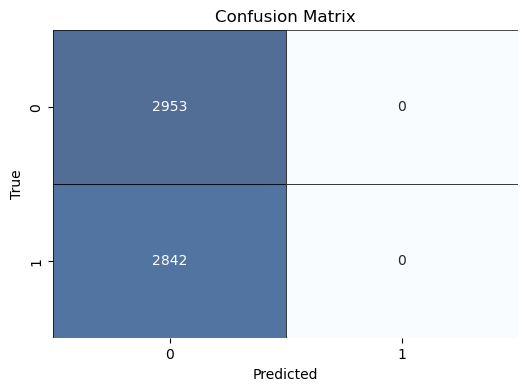

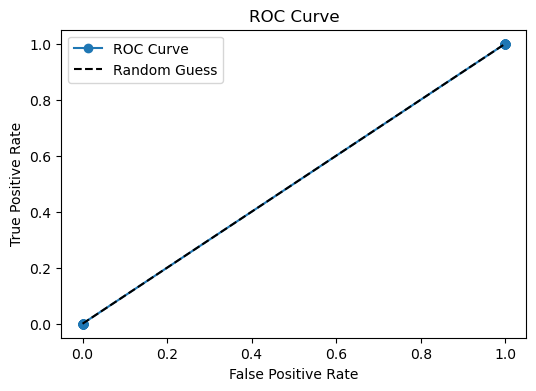

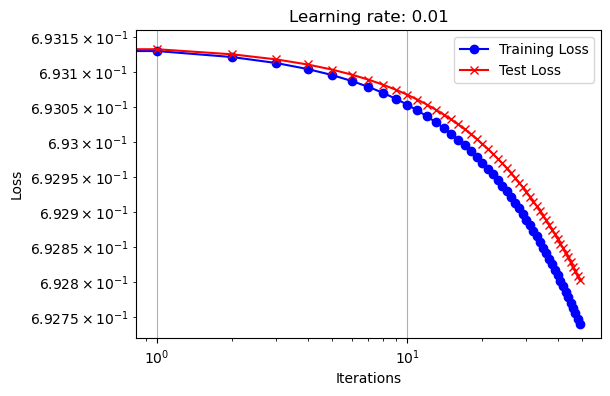

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

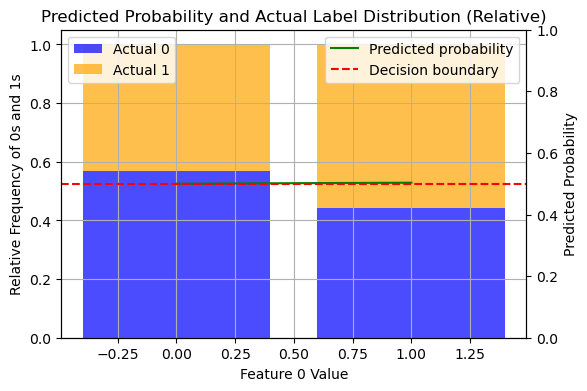

In [15]:

X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
features_dict = { 'SEX': {'type': 'binary', 'missing_values': [np.nan]},}

X_train_transformed = transform_features_column_median(X_train_balanced, features_dict, features)
print(X_train_transformed)
F1_score = one_run_logistic_regression(X_train_transformed, Y_train_balanced, 
                                               max_iters=50, gamma=0.01, reg_norm='l2', 
                                               prob_threshold=0.6, batch_size=N, plot=True)

Bigger probability of MHCID: male (1)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
[ 8.47282140e-05 -3.45125108e-06]
[ 1.69260442e-04 -6.90178481e-06]
[ 2.53597137e-04 -1.03516013e-05]
[ 3.37738752e-04 -1.38007008e-05]
[ 4.21685737e-04 -1.72490834e-05]
[ 5.05438544e-04 -2.06967492e-05]
[ 5.88997620e-04 -2.41436985e-05]
[ 6.72363415e-04 -2.75899312e-05]
[ 7.55536376e-04 -3.10354477e-05]
[ 8.38516947e-04 -3.44802480e-05]
[ 9.21305575e-04 -3.79243323e-05]
[ 1.00390270e-03 -4.13677008e-05]
[ 1.08630878e-03 -4.48103535e-05]
[ 1.16852423e-03 -4.82522907e-05]
[ 1.25054952e-03 -5.16935124e-05]
[ 1.33238507e-03 -5.51340189e-05]
[ 1.41403132e-03 -5.85738103e-05]
[ 1.49548872e-03 -6.20128867e-05]
[ 1.57675770e-03 -6.54512483e-05]
[ 1.65783869e-03 -6.88888953e-05]
[ 1.73873213e-03 -7.23258277e-05]
[ 1.81943846e-03 -7.57620457e-05]
[ 1.89995811e-03 -7.91975495e-05]
[ 1.98029150e-03 -8.26323393e-05]
[ 2.06043907e-03 -8.60664151e-05]
[ 2.14040126e-03 -8.94997771e-05]
[ 2.22017848e-03 -9.29324255e-05]
[ 2.29977117e-03 -9.63643605e-05]


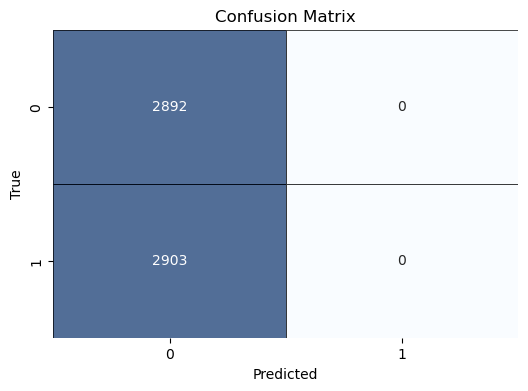

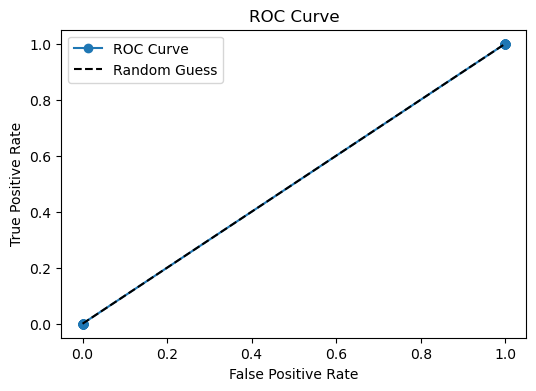

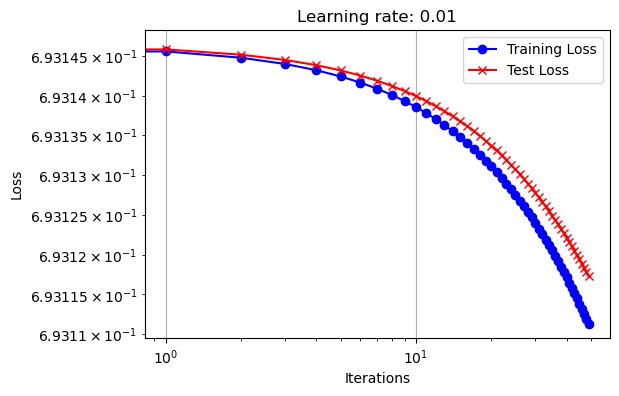

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

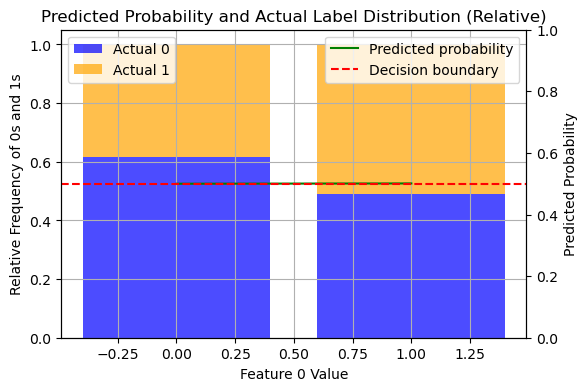

In [16]:

X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
features_dict = {'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]}}

X_train_transformed = transform_features_column_median(X_train_balanced, features_dict, features)
print(X_train_transformed)
F1_score = one_run_logistic_regression(X_train_transformed, Y_train_balanced, 
                                               max_iters=50, gamma=0.01, reg_norm='l2', 
                                               prob_threshold=0.6, batch_size=N, plot=True)

Bigger probability if person has health coverage.

In [ ]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
features_dict = {'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]}}

X_train_transformed = transform_features_column_median(X_train_balanced, features_dict, features)
print(X_train_transformed)
F1_score = one_run_logistic_regression(X_train_transformed, Y_train_balanced, 
                                               max_iters=50, gamma=0.01, reg_norm='l2', 
                                               prob_threshold=0.6, batch_size=N, plot=True)

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [1 0]
 [0 0]]
[2.08455565e-04 7.07506471e-06]
[4.16762100e-04 1.41486222e-05]
[6.24919711e-04 2.12206729e-05]
[8.32928504e-04 2.82912170e-05]
[1.04078859e-03 3.53602549e-05]
[1.24850006e-03 4.24277868e-05]
[1.45606304e-03 4.94938132e-05]
[1.66347763e-03 5.65583343e-05]
[1.87074393e-03 6.36213505e-05]
[2.07786205e-03 7.06828621e-05]
[2.28483210e-03 7.77428693e-05]
[2.49165418e-03 8.48013726e-05]
[2.69832839e-03 9.18583722e-05]
[2.90485485e-03 9.89138684e-05]
[0.00311123 0.00010597]
[0.00331746 0.00011302]
[0.00352355 0.00012007]
[0.00372949 0.00012712]
[0.00393527 0.00013417]
[0.00414092 0.00014122]
[0.00434641 0.00014826]
[0.00455176 0.0001553 ]
[0.00475696 0.00016235]
[0.00496202 0.00016939]
[0.00516692 0.00017643]
[0.00537169 0.00018346]
[0.0055763 0.0001905]
[0.00578077 0.00019753]
[0.00598509 0.00020457]
[0.00618927 0.0002116 ]
[0.0063933  0.00021863]
[0.00659718 0.00022566]
[0.00680092 0.00023268]
[0.00700452 0.00023971]
[0.00720797 0.00024673]
[0

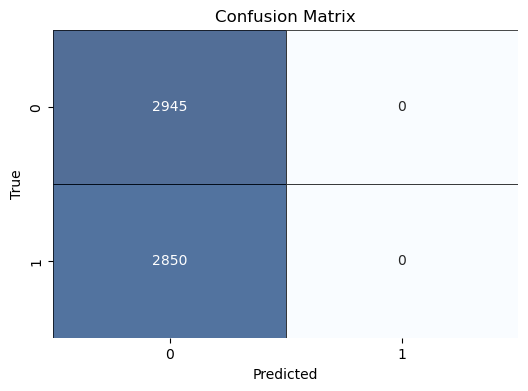

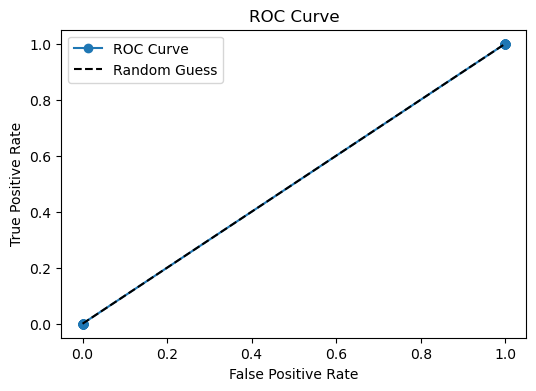

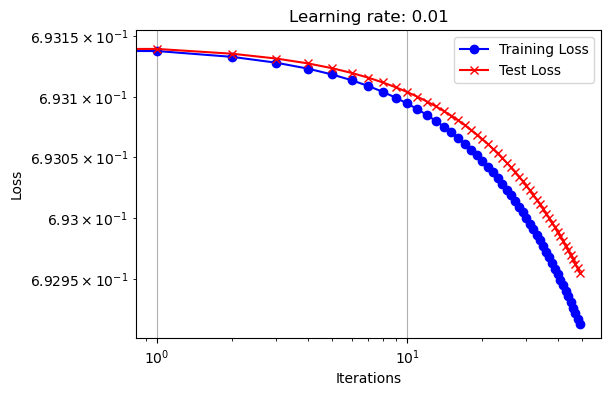

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

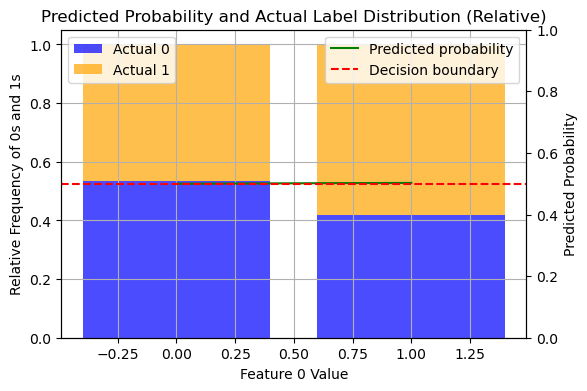

In [17]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
features_dict = {'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, np.nan]}}

X_train_transformed = transform_features_column_median(X_train_balanced, features_dict, features)
print(X_train_transformed)
F1_score = one_run_logistic_regression(X_train_transformed, Y_train_balanced, 
                                               max_iters=50, gamma=0.01, reg_norm='l2', 
                                               prob_threshold=0.6, batch_size=N, plot=True)

Depressive disorder: Yes, bigger prob

[[0 0]
 [1 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]
[3.22519413e-04 1.38912856e-05]
[6.44902278e-04 2.77796437e-05]
[9.67148651e-04 4.16650750e-05]
[1.28925859e-03 5.55475800e-05]
[1.61123215e-03 6.94271593e-05]
[1.93306940e-03 8.33038137e-05]
[2.25477039e-03 9.71775437e-05]
[0.00257634 0.00011105]
[0.00289776 0.00012492]
[0.00321906 0.00013878]
[0.00354021 0.00015264]
[0.00386123 0.0001665 ]
[0.00418212 0.00018036]
[0.00450287 0.00019421]
[0.00482348 0.00020806]
[0.00514396 0.00022191]
[0.0054643  0.00023575]
[0.0057845 0.0002496]
[0.00610457 0.00026343]
[0.00642451 0.00027727]
[0.00674431 0.0002911 ]
[0.00706397 0.00030493]
[0.0073835  0.00031876]
[0.0077029  0.00033258]
[0.00802215 0.00034641]
[0.00834128 0.00036022]
[0.00866026 0.00037404]
[0.00897912 0.00038785]
[0.00929783 0.00040166]
[0.00961642 0.00041547]
[0.00993487 0.00042927]
[0.01025318 0.00044307]
[0.01057136 0.00045687]
[0.0108894  0.00047067]
[0.01120731 0.00048446]
[0.01152508 0.00049825]
[0.01184272 0.00051203]
[0.0121602

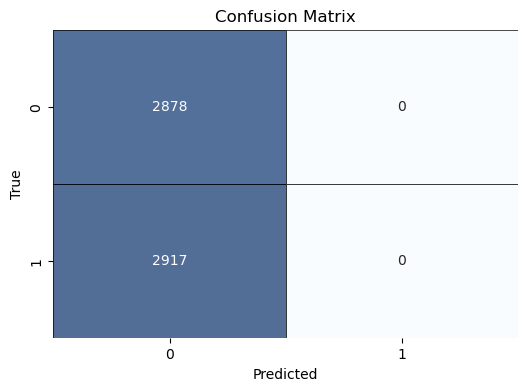

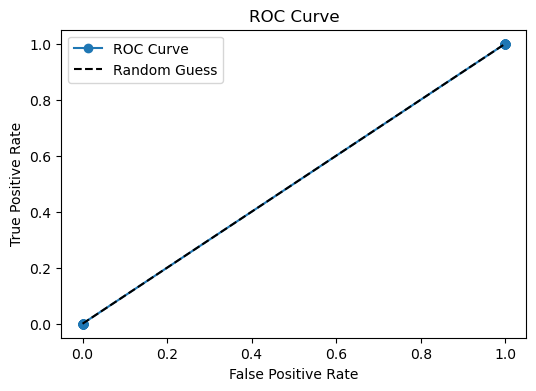

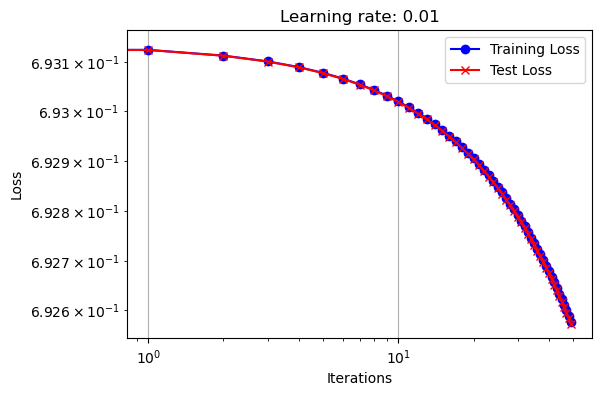

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

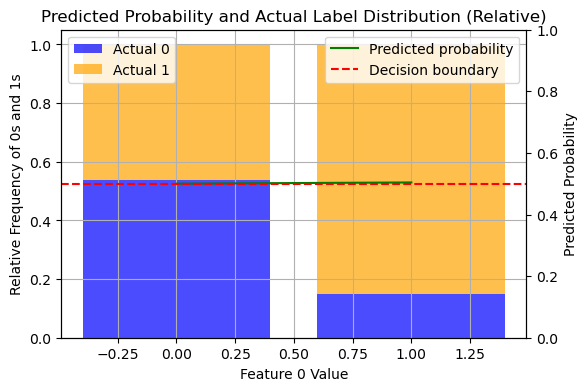

In [18]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
features_dict = {'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}}

X_train_transformed = transform_features_column_median(X_train_balanced, features_dict, features)
print(X_train_transformed)
F1_score = one_run_logistic_regression(X_train_transformed, Y_train_balanced, 
                                               max_iters=50, gamma=0.01, reg_norm='l2', 
                                               prob_threshold=0.6, batch_size=N, plot=True)

Diagnosed with stroke: yes, bigger prob.

[[0 0]
 [1 0]
 [1 0]
 ...
 [0 0]
 [0 0]
 [0 0]]
[3.96117343e-04 1.82053494e-05]
[7.92020067e-04 3.64067083e-05]
[1.18770829e-03 5.46040775e-05]
[1.58318213e-03 7.27974578e-05]
[1.97844170e-03 9.09868503e-05]
[0.00237349 0.00010917]
[0.00276832 0.00012735]
[0.00316294 0.00014553]
[0.00355734 0.0001637 ]
[0.00395153 0.00018187]
[0.00434551 0.00020004]
[0.00473927 0.0002182 ]
[0.00513282 0.00023636]
[0.00552615 0.00025451]
[0.00591928 0.00027266]
[0.00631219 0.00029081]
[0.00670489 0.00030895]
[0.00709737 0.00032709]
[0.00748964 0.00034522]
[0.0078817  0.00036335]
[0.00827355 0.00038148]
[0.00866518 0.0003996 ]
[0.00905661 0.00041771]
[0.00944782 0.00043583]
[0.00983882 0.00045394]
[0.0102296  0.00047204]
[0.01062018 0.00049015]
[0.01101054 0.00050824]
[0.01140069 0.00052634]
[0.01179063 0.00054443]
[0.01218036 0.00056251]
[0.01256988 0.0005806 ]
[0.01295919 0.00059867]
[0.01334828 0.00061675]
[0.01373717 0.00063482]
[0.01412584 0.00065288]
[0.01451431 0.00067095]
[0.01490256 0.00068901]


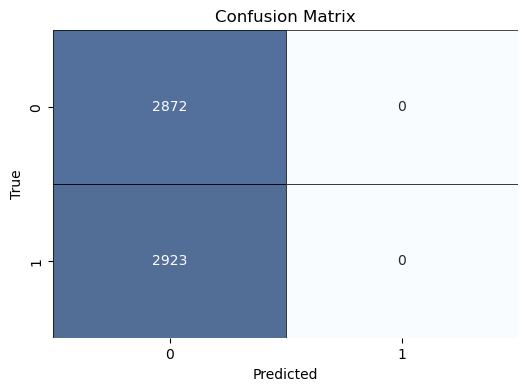

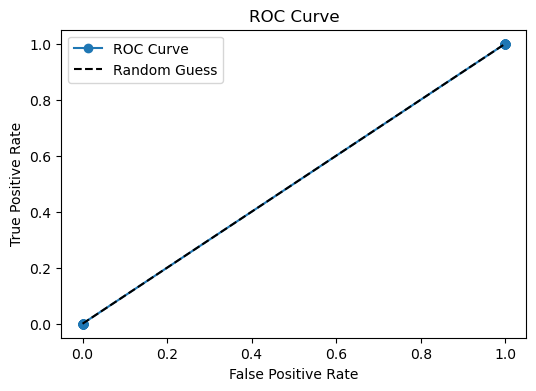

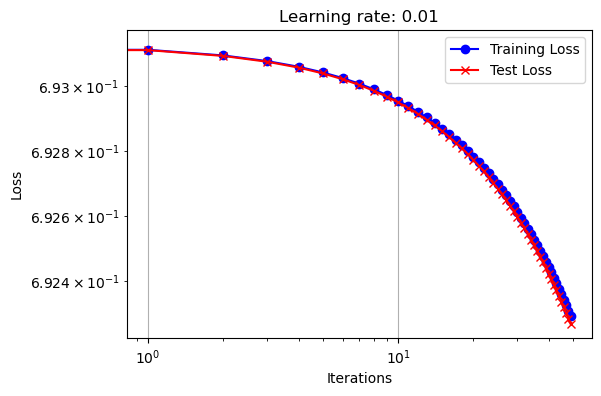

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

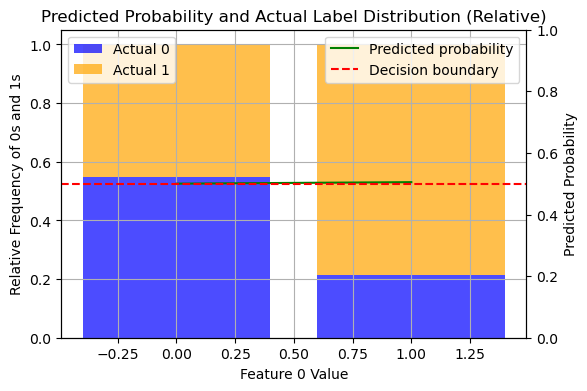

In [19]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
features_dict = {'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]}}

X_train_transformed = transform_features_column_median(X_train_balanced, features_dict, features)
print(X_train_transformed)
F1_score = one_run_logistic_regression(X_train_transformed, Y_train_balanced, 
                                               max_iters=50, gamma=0.01, reg_norm='l2', 
                                               prob_threshold=0.6, batch_size=N, plot=True)

Ever diagnosed with COPD: YES, BIGGER prob

In [ ]:
X_train_balanced, Y_train_balanced = balance_dataset(x_train, Y_train)
N = Y_train_balanced.shape[0]
features_dict = {'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, np.nan]}}

X_train_transformed = transform_features_column_median(X_train_balanced, features_dict, features)
print(X_train_transformed)
F1_score = one_run_logistic_regression(X_train_transformed, Y_train_balanced, 
                                               max_iters=50, gamma=0.01, reg_norm='l2', 
                                               prob_threshold=0.6, batch_size=N, plot=True)

In [ ]:
features_dict = {
    # Binary variables
    'HLTHPLN1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'ADDEPEV2': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CVDSTRK3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'CHCCOPD1': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    'SEX': {'type': 'binary', 'missing_values': [np.nan]},
    'ASTHMA3': {'type': 'binary', 'missing_values': [7, 9, np.nan]},
    
    # Categorical variable
    '_RACEGR3': {
        'type': 'categorical', 
        'missing_values': [9, np.nan],
        'categories': [1, 2, 3, 4, 5]  
    },
    
    # Numeric variables with ranges
    'MENTHLTH': {
        'type': 'numeric', 
        'missing_values': [77, 99, np.nan],
        'range': (1, 30),  
        'map_value': {88: 0} 
    },
    '_AGEG5YR': {
        'type': 'numeric', 
        'missing_values': [14, np.nan],
        'range': (1, 13)  
    }
}

In [38]:
features_dict = {
    
    '_AGEG5YR': {
        'type': 'numeric', 
        'missing_values': [14, np.nan],
        'range': (1, 13)  
    }
}

  0%|          | 0/1 [00:00<?, ?it/s]

[12.  1.  1. 11.  8. 11.  7.  8.  4.  9.]
_AGEG5YR
246
[12.  1.  1. 11.  8. 11.  7.  8.  4.  9.]
[12.  1.  1. ... 10. 12. 10.]
[12.  1.  1. ... 10. 12. 10.]
features:  ('_AGEG5YR',)


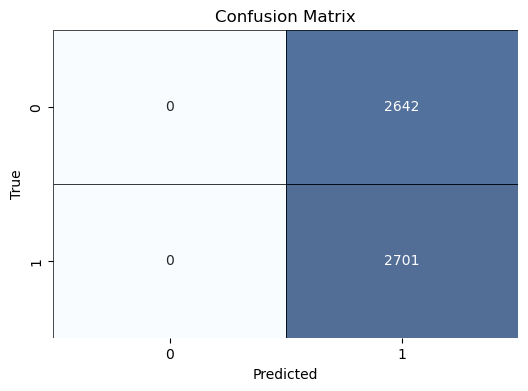

[[12.]
 [ 1.]
 [ 1.]
 ...
 [10.]
 [12.]
 [10.]]
Sample of feature values and their corresponding labels and predictions:
Feature values (test set): [11.  8. 10.  7. 11. 13.  6. 11.  7. 11.]
Actual labels (test set): [1. 1. 1. 0. 1. 1. 0. 1. 0. 0.]
Predicted labels: [1 1 1 1 1 1 1 1 1 1]


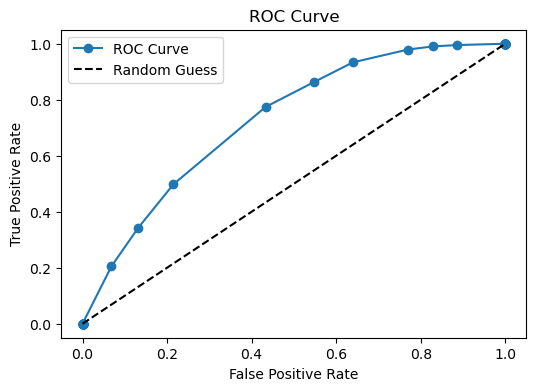

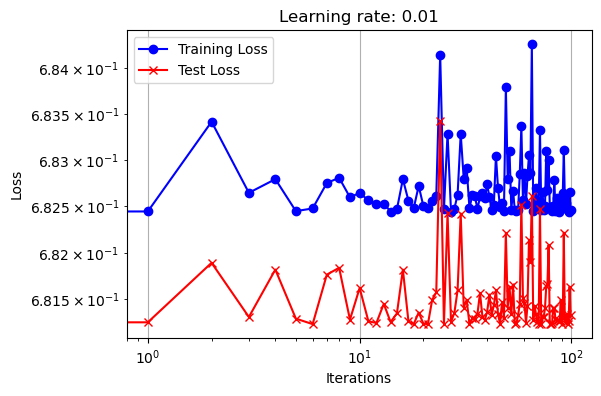

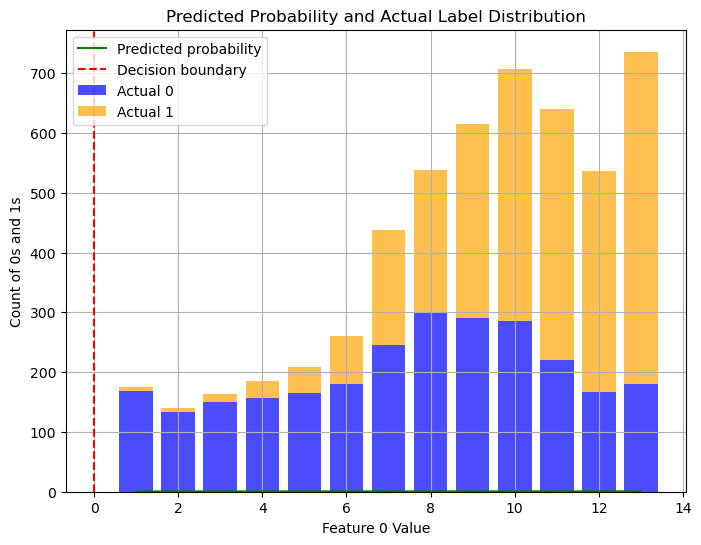

100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

Features: ('_AGEG5YR',), F1 Score: 0.6715564395822974


In [39]:
# Additional column for missing and 0 for missing value
mandatory_features = ['_AGEG5YR'] 
#mandatory_features = [] 
results = evaluate_feature_combinations_with_mandatory(features_dict, X_train_balanced, Y_train_balanced, r=1, mandatory_features=mandatory_features, plot=True)
for result in results:
    print(f"Features: {result['features']}, F1 Score: {result['F1_score']}")

In [13]:
features.index('_AGEG5YR')
x_train[:10,246]

array([ 8.,  8., 10., 10., 14.,  8., 13., 13.,  8.,  8.])